# Moscow housing prediction

By Hauk Aleksander Olaussen, Charbel Badr and Noran Baskaran

## About the group

TODO

## Introduction

For this project we were tasked to create a machine learning algorithm that could predict house prices in Moscow based on a set of houring features and known prices for the given house or apartment.
This notebook will give insight into how we explored the data to find out if any of the data was related to each other, and vice versa. It will show how we altered and formed the given dataset into something our machine learning model would understand better by removing features that does not have as much influence on the price, and adding features that did. This way, we managed to improve the score of the algorithm by engineering the data to our advantage.

Through the notebook, we will give examples in text, code and images (graphs) to give a complete discussion, allowing you to follow our thought process all the way from initial thoughts to finished model.

We will seperate the notebook into sections, making it easy to follow:
* **Data exploration and cleaning**
* **Feature engineering**
* **Trying different models**
* **Tuning hyperparameters**
* **Analyzing the error**

These will intertwine in later sections, as molding the data is a complicated process.


The following code will allow us to auto reload code when changes are made.

In [4]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We begin with importing external and self made modules. Below you can see a description of the modules used:

- `numpy` is the defacto python package for numerical calculation. Most other numerical libraries (including pandas) is based on numpy.
- `pandas` is a widely used package for manipulating (mostly) tabular data
- `matplotlib` is the most used plotting library for python
- `seaborn` contains several convience functions for matplotlib and integrates very well with pandas
- `train_test_split` used for splitting training data into actual training and validation data
- `Visualizer` contains several functions used to plot different parts of the data and their correlation
- `Preprocessor` contains the main bulk of code used to preprocess and feature engineer the data provided to transform the data into something more understandable to a model
- `Model` contiains the model used for predicting the price of an apartment or house based on the data preprocessed by Preprocessor


In [107]:
%autoreload
 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from Visualizer import Visualizer
from Preprocessor import Preprocessor
from Model import Model
from TestModel import TestModel

sns.set_style('darkgrid')
pd.set_option("display.max_columns", None)

## Data exploration and cleaning

In this section we want to get a good look at the data. We want to find out what datatypes we must work with, how the structure looks like, and if we have any *NaN* values we need to work around.
The dataset is split into two different files - namely **buildings** and **apartments**. Apartments have a field which points to a building, connecting the two. This is something we will have to look at later in the process, as a building has a lot to say about the standards of the apartment. 

Below you can see the head entries for both the *apartments* and *buildings*.

### Apartments

#### Training data

In [6]:
preprocessor = Preprocessor()
apartments = preprocessor.apartments
apartments.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,0.0,2.0,0.0,1.0,NaN,NaN,NaN,1.0,4076
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,2.0,0.0,1.0,1.0,1.0,0.0,3.0,1.0,1893
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,0.0,2.0,1.0,1.0,NaN,NaN,NaN,1.0,5176
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,0.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0,1893
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,1.0,0.0,1.0,1.0,0.0,1.0,3.0,1.0,6604


#### Test data

In [7]:
apartments_test = preprocessor.apartments_test
apartments_test.head()

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,1.0,'5148'
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,NaN,1.0,0.0,NaN,NaN,3.0,1.0,1290
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,0.0,1.0,0.0,NaN,NaN,NaN,1.0,681
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,4261
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,7530


### Buildings

#### Training data

In [8]:
buildings = preprocessor.buildings
buildings.head()

,id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,264,0.0,55.518117,37.355139,11.0,улица 1-я Нововатутинская,3,2019.0,2.0,12.0,1.0,1.0,1.0,0.0,1.0,3.0
1,6079,0.0,55.641920,37.352156,7.0,мкр. 10-й,к1014,1981.0,3.0,22.0,0.0,1.0,1.0,NaN,1.0,0.0
2,5829,0.0,55.770011,37.386220,7.0,Рублевское шоссе,68,2002.0,3.0,24.0,0.0,1.0,1.0,NaN,NaN,0.0
3,5758,0.0,55.739934,37.426070,7.0,Рублевское шоссе,93К2,2011.0,3.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0
4,6761,0.0,55.649921,37.467994,7.0,улица Академика Анохина,58К2,2005.0,3.0,22.0,0.0,1.0,1.0,NaN,0.0,0.0


#### Test data

In [9]:
buildings_test = preprocessor.buildings_test
buildings_test.head()

,id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,6659,0.0,55.802771,37.510709,1.0,улица Алабяна,3К3,1962.0,0.0,8.0,0.0,1.0,0.0,NaN,1.0,0.0
1,369,1.0,55.511730,37.351958,11.0,Кленовые Аллеи ЖК,к2,2020.0,NaN,15.0,0.0,1.0,1.0,1.0,NaN,NaN
2,5658,0.0,55.865763,37.541790,1.0,Коровинское шоссе,3К1,1967.0,3.0,9.0,0.0,1.0,0.0,NaN,1.0,0.0
3,5903,0.0,55.848640,37.516745,1.0,3-й Лихачевский переулок,5,1985.0,3.0,14.0,0.0,1.0,1.0,NaN,1.0,0.0
4,7782,1.0,55.499290,37.521309,11.0,Остафьево ЖК,к6,2020.0,2.0,13.0,1.0,1.0,1.0,1.0,0.0,NaN


**Great!**
This gives us some initial insight on how the data looks. We see that we have a lot of different features here. Some of them will probably not influence the price at all (or at least to a very low degree), and some may influence the price a great deal. The data has a combination of numerical, ordinal and categorical features, which is good. This variety opens a lot of doors for us when we are to explore and engineer the data later.

We can also see that we have a lot of *NaN* values in the data - which is something we will have to deal with.

First, let us combine the **apartments** and **buildings** based in the *bulding_id* field to get a better look.

### Merging apartments and buldings

#### Training data

In [10]:
merged = preprocessor.merged.copy()
merged.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,0.0,2.0,0.0,1.0,NaN,NaN,NaN,1.0,4076,1.0,55.544046,37.478055,11.0,Бунинские Луга ЖК,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,2.0,0.0,1.0,1.0,1.0,0.0,3.0,1.0,1893,0.0,55.861282,37.666647,2.0,улица Радужная,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,0.0,2.0,1.0,1.0,NaN,NaN,NaN,1.0,5176,1.0,55.663299,37.515335,6.0,Саларьево Парк ЖК,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,0.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0,1893,0.0,55.861282,37.666647,2.0,улица Радужная,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,1.0,0.0,1.0,1.0,0.0,1.0,3.0,1.0,6604,0.0,55.590785,37.451438,11.0,улица Сервантеса,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


#### Test data

In [11]:
merged_test = preprocessor.merged_test.copy()
merged_test.head()

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,1.0,5148,0.0,55.762247,37.549040,0.0,2-я Черногрязская улица,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,NaN,1.0,0.0,NaN,NaN,3.0,1.0,1290,0.0,55.591467,37.452651,11.0,улица Сервантеса,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,0.0,1.0,0.0,NaN,NaN,NaN,1.0,681,1.0,55.617017,37.413718,11.0,Саларьево Парк ЖК,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,4261,0.0,55.569052,37.479510,11.0,улица Александры Монаховой,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,7530,0.0,55.518041,37.343829,11.0,улица 3-я Нововатутинская,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0


### Merging the training and test sets into one
We will now merge these dataframes into one. We do this so we can be sure that the preprocessing is uniform across both the training, and test set. One important thing to remember is that the test set does not have a *price* feature, as this is the whole task. Because of this, we will need to remember where the training data stops, and the test data starts. This happens as index ***23284***


In [12]:
merged_final = pd.concat([merged, merged_test], ignore_index=True)
print(f"The dataframe now has {len(merged_final)} entries")

The dataframe now has 33222 entries


### Finding the NaNs
Lets see how many *NaN* values we are dealing with for each feature in the newly created combined dataframe.

In [13]:
visualizer = Visualizer()
visualizer.list_missing(merged_final.copy())

Total length: 33222
id: Amount: 0 | 0.0%
seller: Amount: 12772 | 38.44%
price: Amount: 9937 | 29.91%
area_total: Amount: 0 | 0.0%
area_kitchen: Amount: 6954 | 20.93%
area_living: Amount: 5901 | 17.76%
floor: Amount: 0 | 0.0%
rooms: Amount: 0 | 0.0%
layout: Amount: 25010 | 75.28%
ceiling: Amount: 16111 | 48.49%
bathrooms_shared: Amount: 5589 | 16.82%
bathrooms_private: Amount: 5589 | 16.82%
windows_court: Amount: 11560 | 34.8%
windows_street: Amount: 11560 | 34.8%
balconies: Amount: 15355 | 46.22%
loggias: Amount: 15355 | 46.22%
condition: Amount: 13769 | 41.45%
phones: Amount: 120 | 0.36%
building_id: Amount: 0 | 0.0%
new: Amount: 373 | 1.12%
latitude: Amount: 2 | 0.01%
longitude: Amount: 2 | 0.01%
district: Amount: 155 | 0.47%
street: Amount: 0 | 0.0%
address: Amount: 0 | 0.0%
constructed: Amount: 1168 | 3.52%
material: Amount: 5643 | 16.99%
stories: Amount: 0 | 0.0%
elevator_without: Amount: 537 | 1.62%
elevator_passenger: Amount: 537 | 1.62%
elevator_service: Amount: 537 | 1.62%
par

We see that the majority of the features has some *NaN* values. Some of them, like *layout* has a lot - **25k** out of **33**. <br>
Multiple fields have over 40% *NaNs*.

Also, notice that price has 9937 *NaN* values, as we have combined the dataframes.

### Initial removing and filling of features
We will remove features with an overwhelming amount of *NaN* values (over 40% in both training and test data), as these will just cause noise in the model, and features consisting of strings (such as the street and address), which will be impossible to categorize. We will also remove the *elevator_without* feature, as the two other elevator feature will tell us what this boolean value should be. All this is done by the `Preprocessor.general_removal()` funciton.

We will also do a general clean-up of the *NaN* values. We do this with the `Preprocessor.remove_NaNs()` function. It will fill in data for all *NaN* values. For continuous values we we do this by calculating some sort of average or mean for each district in a combined set of both training and test data. For categorical values, this is mostly done by using the most used value - or *mode*. Apartments without a district will use the closest neighboors district.

In [14]:
general_removed = preprocessor.general_removal(merged_final.copy())
data = preprocessor.remove_NaNs(general_removed.copy())
visualizer.list_missing(data)

Total length: 33222
id: Amount: 0 | 0.0%
seller: Amount: 0 | 0.0%
price: Amount: 9937 | 29.91%
area_total: Amount: 0 | 0.0%
area_kitchen: Amount: 0 | 0.0%
area_living: Amount: 0 | 0.0%
floor: Amount: 0 | 0.0%
rooms: Amount: 0 | 0.0%
bathrooms_shared: Amount: 0 | 0.0%
bathrooms_private: Amount: 0 | 0.0%
windows_court: Amount: 0 | 0.0%
windows_street: Amount: 0 | 0.0%
phones: Amount: 0 | 0.0%
building_id: Amount: 0 | 0.0%
new: Amount: 0 | 0.0%
latitude: Amount: 0 | 0.0%
longitude: Amount: 0 | 0.0%
district: Amount: 0 | 0.0%
constructed: Amount: 0 | 0.0%
material: Amount: 0 | 0.0%
stories: Amount: 0 | 0.0%
elevator_passenger: Amount: 0 | 0.0%
elevator_service: Amount: 0 | 0.0%
parking: Amount: 0 | 0.0%
garbage_chute: Amount: 0 | 0.0%
heating: Amount: 0 | 0.0%


This proves we have removed all the *NaN* values in the dataset except price, which makes sense.<br>
The head now looks like this

In [15]:
data.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,0.0,2.0,0.0,1.0,1.0,4076,1.0,55.544046,37.478055,11.0,2021.0,3.0,9.0,1.0,1.0,1.0,-1.0,-1.0
1,1,-1.0,10500000.0,88.0,14.2,48.0,18.0,3.0,2.0,0.0,1.0,1.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,-1.0,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,0.0,2.0,1.0,1.0,1.0,5176,1.0,55.663299,37.515335,6.0,2021.0,3.0,15.0,1.0,1.0,1.0,-1.0,-1.0
3,3,-1.0,10500000.0,88.0,14.0,48.0,18.0,3.0,0.0,2.0,1.0,1.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,-1.0,0.0
4,4,-1.0,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,0.0,1.0,1.0,1.0,6604,0.0,55.590785,37.451438,11.0,2017.0,2.0,15.0,1.0,1.0,1.0,0.0,0.0


### Visualizing the distribution of features
Below, you can see graphs for all the features in the merged dataframe. It gives some insight into how the data is distributed across the dataset.

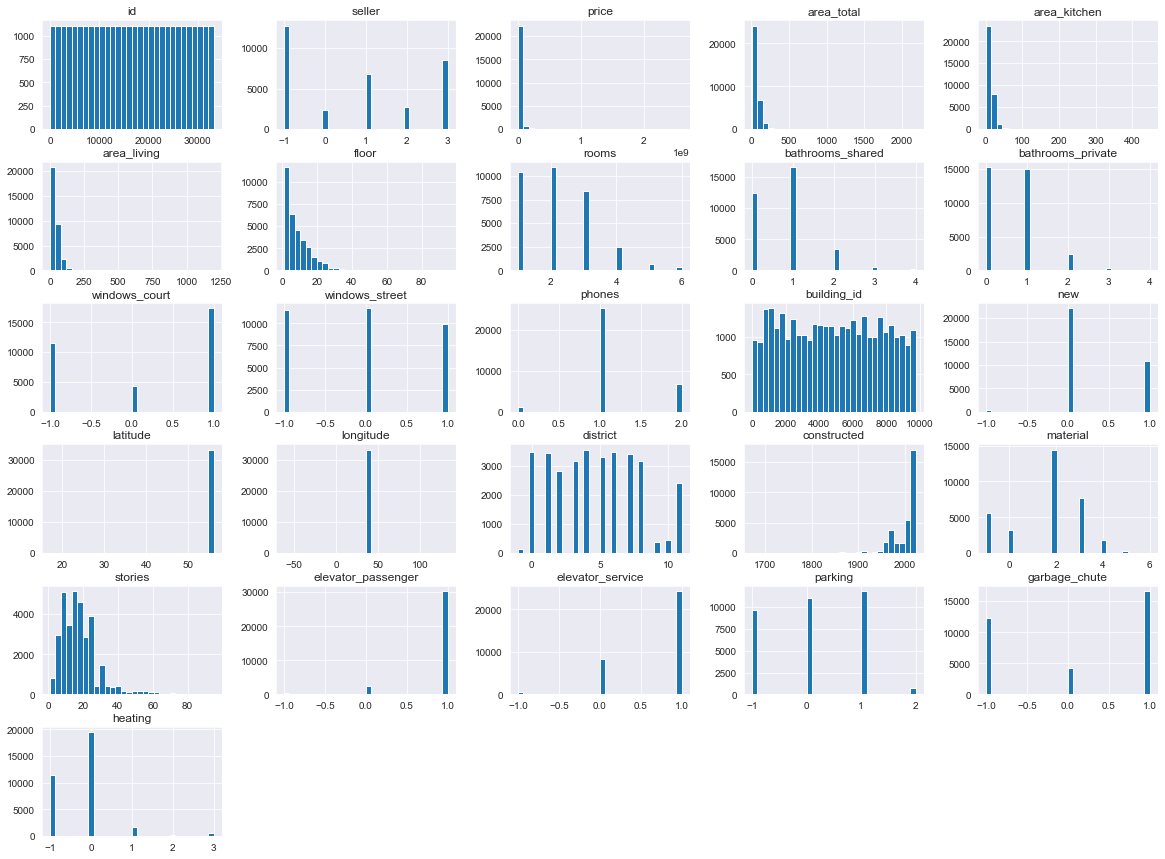

In [16]:
data.hist(bins=30, figsize=(20,15))
plt.show()

What we are looking for here are data with odd distributions. We can see that some of these diagrams are heavily "one sided". What we mean by this is that some of the data has mostly one value, or is skewed in some way. We can remove this by taking the logarithm of the given variables. We start doing this in the feature engineering part

### Visualizing correlations

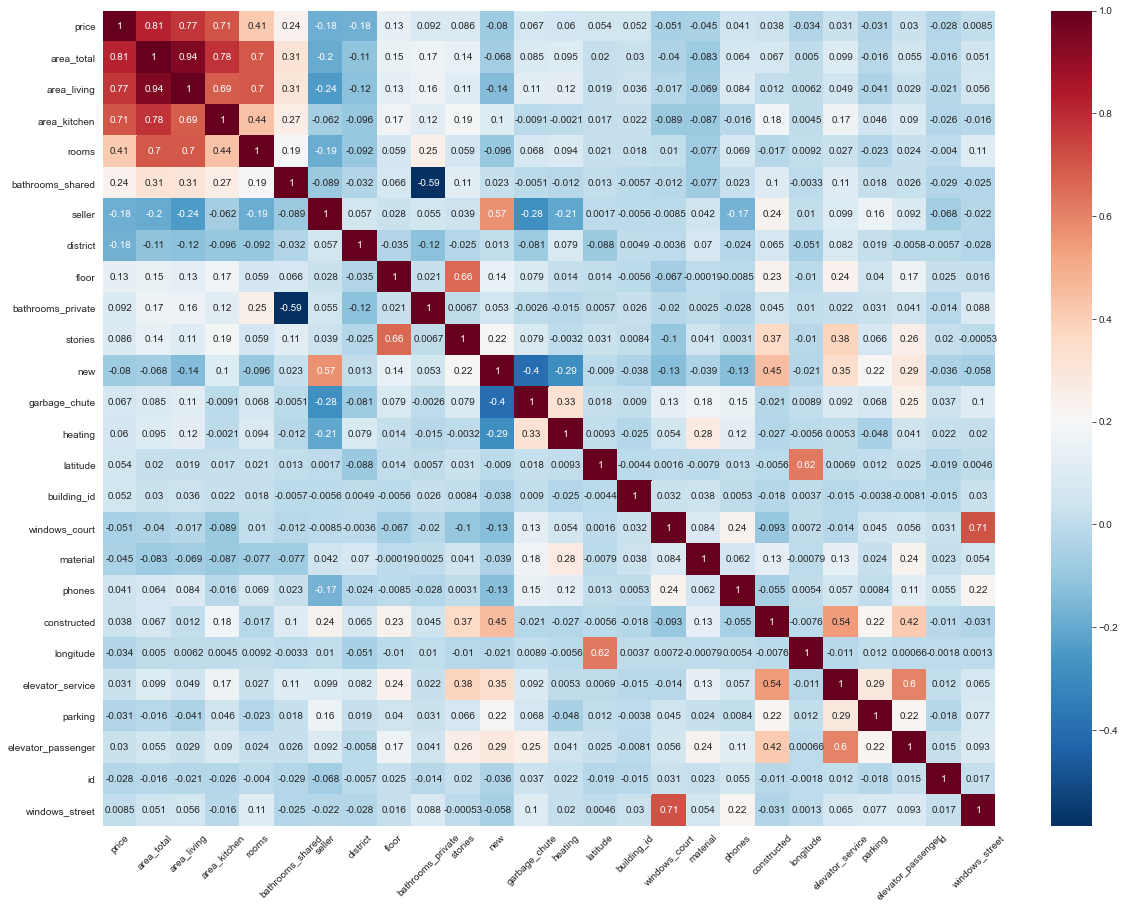

In [17]:
visualizer.price_correlation(data)

**Whoa!**<br>
That was quite a grid.
We can however remove some more features just by looking at this grid. There are some features with next to none correlation with the price, and some with a very high correlation.

Below is a summary of the correlations we can see between the data that have made it through the cleaning so far.. <br>
Some takeouts:
- Total area, living area, kitchen area and price are very correlated
- Amount of rooms and price are highly correlated
- Parking and price are somewhat correlated
- Amount of stories in the building and apartment floor are highly correlated
- Bathrooms private and bathrooms shared are very negatively correlated
- New and seller are somewhat correlated
- Windows street and windows court are very negatively correlated
- District and latitude/longitude are very correlated
- Constructed and the elevator features are highly correlated

## More exploration and some feature altering

Lets continue the exploration by plotting some of the distrubutions of the features with the highest correlation to price.<br>
We start with the price itself.

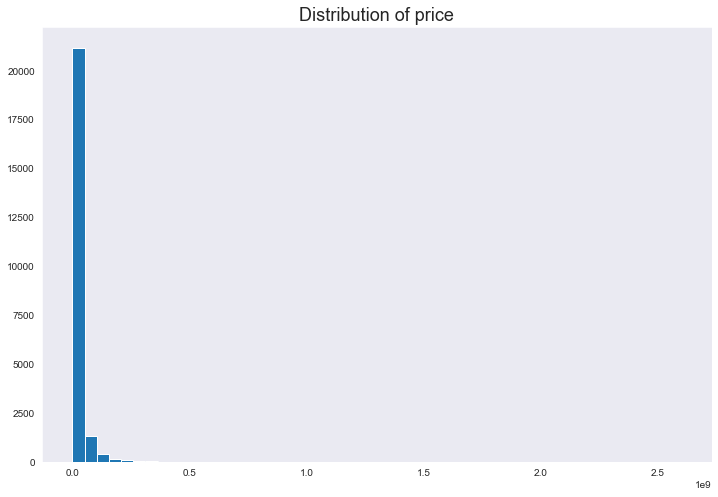

In [18]:
visualizer.plot_distribution(data, "price")

As we mentioned earlier, we can see that this value is heavily skewed. By taking the logarithm of the price, we get a much more spread out target for the algorithm. This will help it pinpointing more accurately where it want the price prediction to be. All we have to to is to convert it back to an actual price value. You can see the logified plot below.

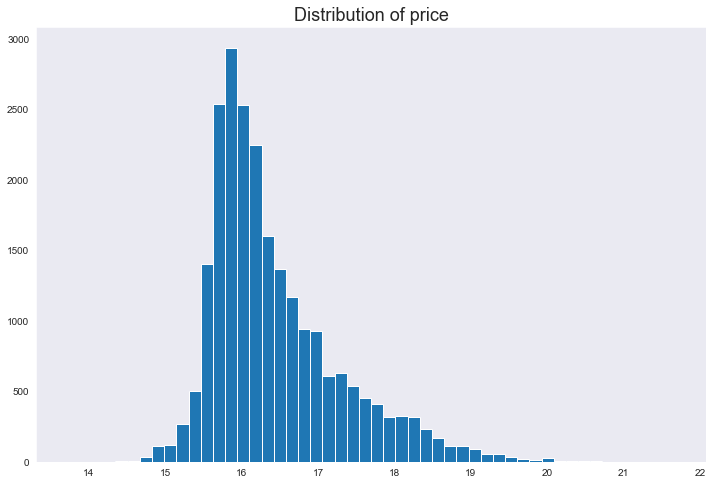

In [19]:
data = preprocessor.logify(data.copy(), "price")
visualizer.plot_distribution(data, "price")

Now we look at the total area. 

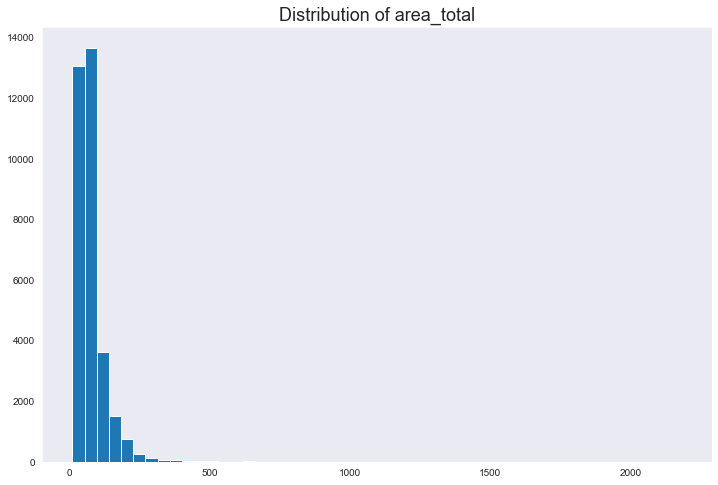

In [20]:
visualizer.plot_distribution(data, "area_total")

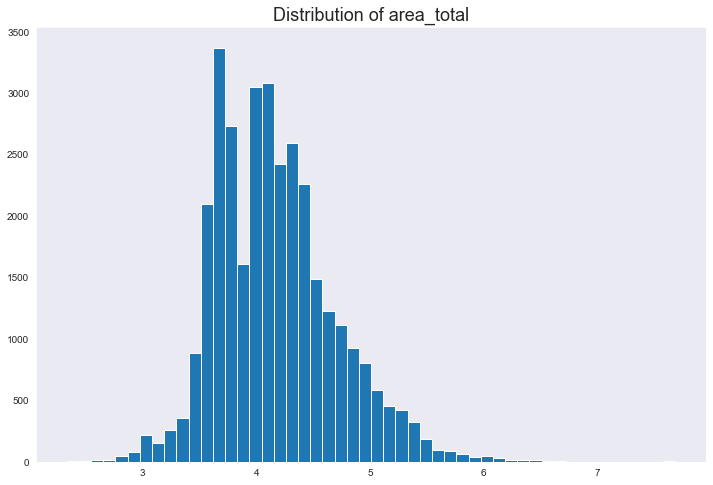

In [21]:
data = preprocessor.logify(data.copy(), "area_total")
visualizer.plot_distribution(data, "area_total")

When taking the logarithm of the total area we get this distribution. This is the feature with the highest correlation to price - which of course is not surprising. It is, however, also highly correlated so some other features, namely living area, kitchen area and the amount of rooms. One way of dealing with this could be to create a new feature with these combined in some way, or by splitting them even further. We will look into this in the feature engineering part of the notebook.

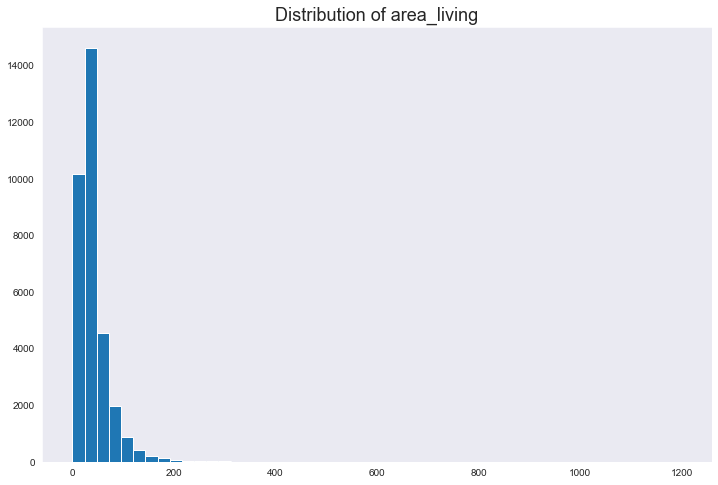

In [22]:
visualizer.plot_distribution(data, "area_living")

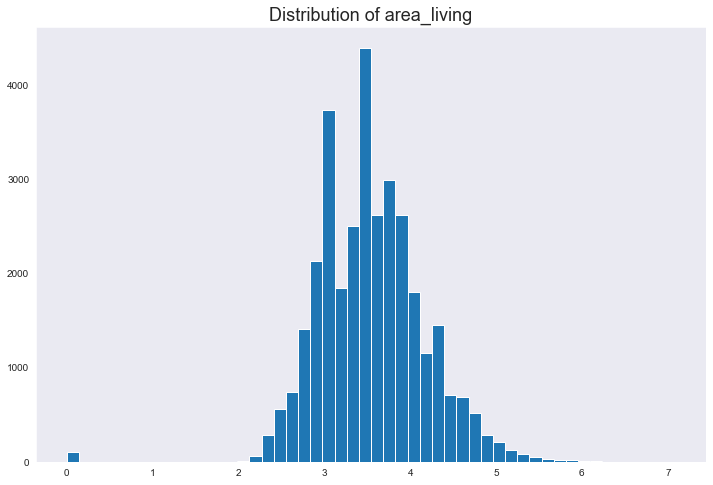

In [23]:
data = preprocessor.logify(data.copy(), "area_living")
visualizer.plot_distribution(data, "area_living")

This shows something worth fixing. The living area will never be 0. This is just as worthless as it being *NaN*. Because of this, we fix it so that the 0 values use the average from their district. The new distribution looks like this:

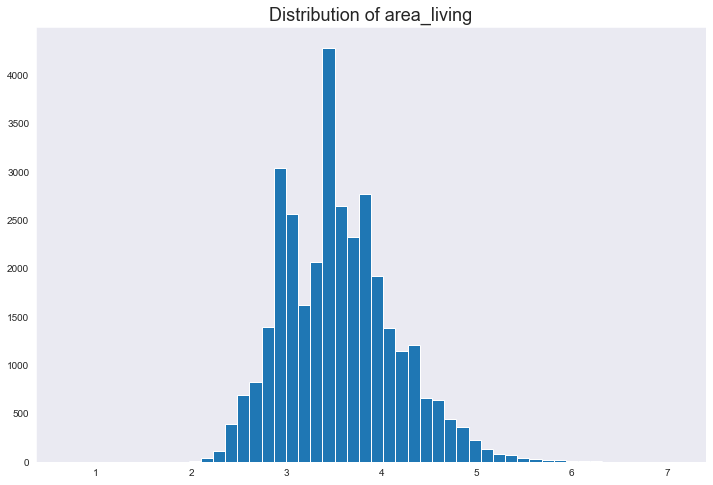

In [24]:
data = preprocessor.remove_zero_values(data.copy(), "area_living")
visualizer.plot_distribution(data, "area_living")

Because this phenomenon was present in the *area_living* feature, we check the *area_kitchen* feature as well.

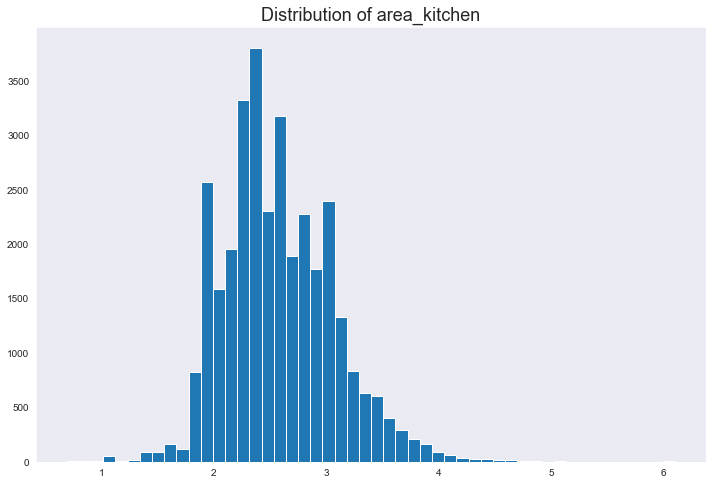

In [25]:
data = preprocessor.logify(data.copy(), "area_kitchen")
visualizer.plot_distribution(data, "area_kitchen")

Luckily, this problem was not present in this column. Still, as the feature was very skewed (as previuosly mentioned), we keep it logified.

## Scattering some correlations

The correlation grid above gives us good insight in how the features are correlated to each other, but is of course not everything we need. In this section we will plot different features against each other to visualize the correlations between them. This may lead to us finding features we want to combine, but may also lead to us finding that we do not need a spesific feature. We will see.

Visualizing the correlations between different features will give us futher insight in how we will transform and change the data in later sections. For plotting with the price, we will use just the training data part of the dataframe, as the test part does not have this feature

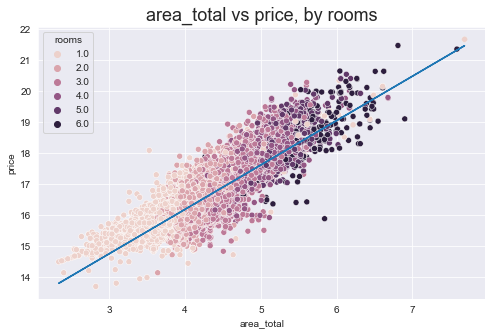

In [26]:
data_with_price = data[:23285].copy()
visualizer.plot_vs(data_with_price, "area_total", "price", reg=True, figsize=(8,5), hue="rooms")

Using rooms as the hue here shows that the more expensive apartments, which are often the largest, also have the most rooms. This shows a clear correlation between total area and the amount of rooms, which we already knew. However, the separation here are quite clear, making it even more obvious that these two depend on each other.

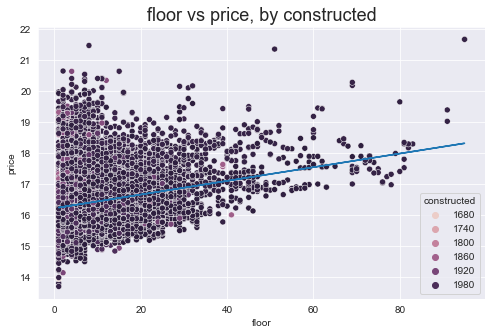

In [27]:
visualizer.plot_vs(data_with_price, "floor", "price", reg=True, figsize=(8,5), hue="constructed")

This shows something interesting. For one it shows that often, the higher the floor, the higher the price. But it also shows that the vast majority of the apartments are build in the 2010s, and they are everywhere on the plot. Meaning that the year of construction might not have as much to say when it comes to price than one might think. Lets plot this.

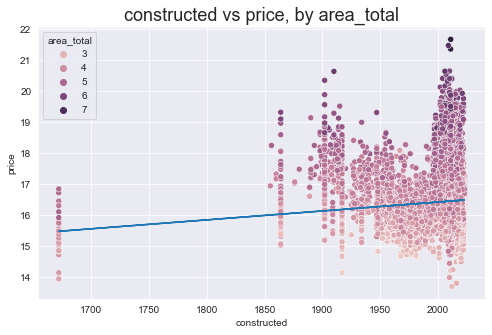

In [28]:
visualizer.plot_vs(data_with_price, "constructed", "price", reg=True, figsize=(8,5), hue="area_total")

Look at that. The price based on contruction year is very scattered around. It look like the construction year does not really matter as much as one might think when it comes to price. You can clearly see "average" vertial lines where we have imputed the valies, but still - it shows that it does not have that much to say for the price of the apartment. We have set the hue to show the total area in this case, showing that even though some of the old buildings are large, they are not that much bigger than apartments in the same price range built many years later. This is fascinating. 

We did not plot all features here, but just a select few, just to show that some of these features are very scattered. This means that even though some correlation does exist, it will be quite hard to know where to place the price for a new apartment based on the training data. 

Before starting the feature engineering, lets plot some of the features against each other, and not only the price. This will give us some insight in how the features are correlated to each other, and not only the price. Maybe we can find a way to create new and better features out of this exploration, like we did with latitude and longitude earlier? Lets see.

#### Exploring features correlated to eachother

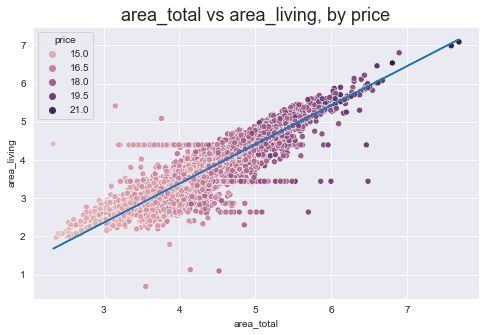

In [29]:
visualizer.plot_vs(data, "area_total", "area_living", reg=True, figsize=(8,5), hue="price")

As we though, total area, living area and rooms are very correlated. The price of the apartment also follows this trend it seems. We will look at this correlation when we start feature engineering as these might be eligible for altering and/or combining.

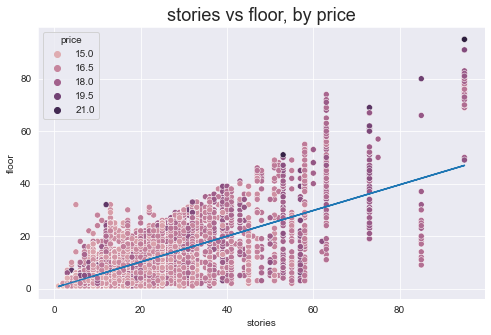

In [30]:
visualizer.plot_vs(data, "stories", "floor", reg=True, figsize=(8,5), hue="price")

This plot shows a clear correlation with stories and floor. Of course, it is not very surprising that apartments on higher floors are in buildings with more stories. The hue here is based on the price, showing some lean towards higher story buldings, and apartments on the higher floors of them. Maybe something to think about 

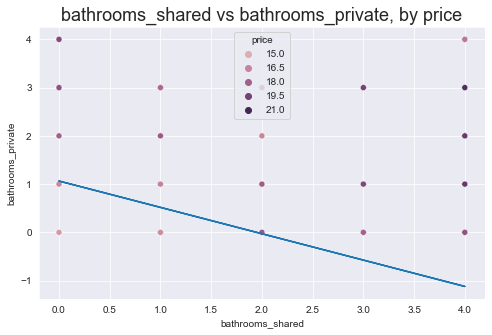

In [31]:
visualizer.plot_vs(data, "bathrooms_shared", "bathrooms_private", reg=True, figsize=(8,5), hue="price")

Nothing very surprising here. When the amount of private bathrooms goes down, the amount of shared bathrooms go up, and vice versa.

Lets look at the latitude and longitude. These are features we will combine later to find the distance to different things around town. They should be pretty similar, as we are located inside the same city.

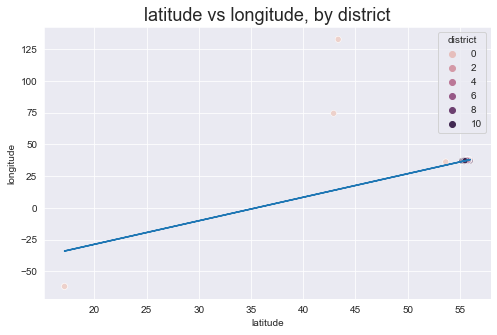

In [32]:
visualizer.plot_vs(data, "latitude", "longitude", reg=True, figsize=(8,5), hue="district")

Now this is weird. We can see almost all the apartments are clumped together around *latitude* = 55 and *longitude* = 35 (roughly), but there are some apartments not even close to the rest. Lets try finding these apartments, and how many they are:

In [33]:
is_outlier = (data["longitude"] > 55) | (data["latitude"] < 54)
outliers = data.copy()[is_outlier]
outliers

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating
23308,23308,-1.0,NaN,3.688879,2.484907,2.772589,6.0,1.0,1.0,0.0,1.0,0.0,1.0,3803,1.0,53.651999,36.264789,-1.0,2019.0,2.0,12.0,1.0,1.0,-1.0,-1.0,-1.0
23375,23375,1.0,NaN,3.754199,2.468100,3.010621,13.0,1.0,1.0,0.0,0.0,1.0,2.0,3803,1.0,53.651999,36.264789,-1.0,2019.0,2.0,12.0,1.0,1.0,-1.0,-1.0,-1.0
25796,25796,-1.0,NaN,3.034953,1.808289,2.341806,11.0,1.0,0.0,1.0,-1.0,-1.0,1.0,4636,1.0,17.141734,-61.790500,-1.0,2021.0,3.0,17.0,0.0,0.0,-1.0,0.0,-1.0
25814,25814,2.0,NaN,3.443618,1.975430,2.870662,1.0,1.0,0.0,1.0,-1.0,-1.0,0.0,4202,-1.0,42.914700,74.517184,-1.0,2016.0,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0
28004,28004,2.0,NaN,5.123964,2.944439,4.836282,5.0,4.0,1.0,2.0,1.0,1.0,1.0,8811,0.0,43.353545,132.768097,-1.0,2007.0,-1.0,5.0,1.0,1.0,1.0,1.0,-1.0
28375,28375,0.0,NaN,3.797734,1.791759,3.394508,4.0,2.0,0.0,1.0,-1.0,-1.0,0.0,4412,1.0,17.141734,-61.790500,-1.0,2021.0,-1.0,9.0,1.0,1.0,-1.0,-1.0,-1.0
30244,30244,-1.0,NaN,3.034953,1.808289,2.341806,11.0,1.0,0.0,1.0,-1.0,-1.0,1.0,4636,1.0,17.141734,-61.790500,-1.0,2021.0,3.0,17.0,0.0,0.0,-1.0,0.0,-1.0
31881,31881,0.0,NaN,3.339322,1.883183,2.769168,17.0,1.0,1.0,0.0,0.0,1.0,1.0,4412,1.0,17.141734,-61.790500,-1.0,2021.0,-1.0,9.0,1.0,1.0,-1.0,-1.0,-1.0
32832,32832,-1.0,NaN,5.247024,3.682204,4.652514,1.0,5.0,0.0,1.0,-1.0,-1.0,1.0,5667,-1.0,43.352968,132.759204,-1.0,1994.0,-1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0


This shows 8 outliers in the dataset. As all of them have *NaN* price, we know that these are from the testset. We can verify this by looking at the *id* field, which tells us that all of the outliers have ids larger than ***23284***. As these are not in the training set, we cannot remove them - because we need to predict prices for them. We will assume that this building is misrepresented in the test data, and will give these apartments the average latitude and longitude in their district. We do this with the function `Preprocessor.fix_latlon_outliers()`.

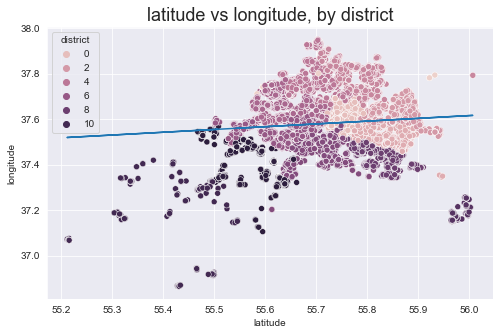

In [34]:
removed_outliers = preprocessor.fix_latlon_outliers(data.copy(), outliers)
visualizer.plot_vs(removed_outliers, "latitude", "longitude", reg=True, figsize=(8,5), hue="district")

**This is better!**
We can clearly see the different districts when we plot the latitude and longitude like this. We see that the apartments gather around a circular center, with the lower numbered districts being closer to center. We can look at this as a city center, which will probably be very important later. This is a fascinating plot, as two features not really correlating that much to the price, will have a big impact when combined later into one feature called *distance_center* - which will be the distance to the city center. 

### TODO - More plotting of features

## Feature engineering

This section is where we will change the data in a more drastic way than we have. We have already cleaned the data, removing NaNs and non-important features, but that does not mean that we will not find a way to combine other non-correlating features into new ones with actual impact. We will try to create features where they correlate to the price in a more impactful manner than they did alone, making it easier for the machine learning algorithm to predict accurately.

We will reference to earlier sections when discussing and explaining our though processes as the insight obtained in the data exploration phase will be used all through this section. 

Earlier in this notebook we did some minor feature engineering when we removed the skew for some features using the logarithm.

In the exploration we found correlations between the total area, living area, kitchen area and the amount of rooms in an apartment. Let's see what one or more combinations of these would look like. <br>
We will create a new features for this: **avg_room_size**, **living_fraction** and **kitchen_fraction**

- **avg_room_size**: the average size of a room in the apartment.
- **living_fraction**: *area_living* / *area_total*
- **kitchen_fraction**: *area_kitchen* / *area_total*

This is done by the function `Preprocessor.combine_area_rooms()`

                  avg_room_size  living_fraction  kitchen_fraction     price
avg_room_size          1.000000        -0.464081          0.236340 -0.450685
living_fraction       -0.464081         1.000000         -0.408683  0.299087
kitchen_fraction       0.236340        -0.408683          1.000000  0.124355
price                 -0.450685         0.299087          0.124355  1.000000


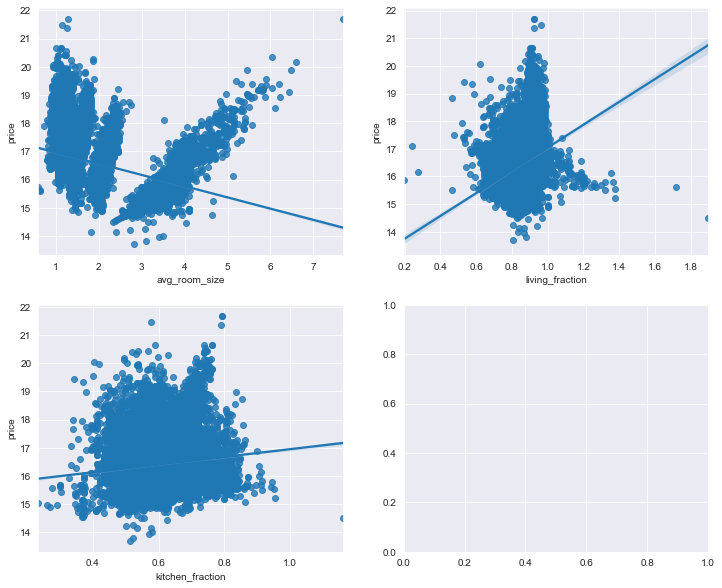

In [35]:
featured = preprocessor.combine_area_rooms(data.copy())
visualizer.corr_target(featured, cols=["avg_room_size", "living_fraction", "kitchen_fraction"], target='price')

We see that the average room size does correlate to the price pretty well, but negatively. This means that the larger the rooms are on average, the lower the price of the apartment is. This is different from the *living_fraction* and *kitchen_fraction* where it is less correlated to the price, but positively. This means that if the living area and kitchen area is larger, the price of the apartment will most likely be higher. We will now remove the features these are based on - *area_living*, *area_kitchen* and *rooms*.

In [36]:
featured = preprocessor.remove_labels(featured.copy(), ["area_living", "area_kitchen", "rooms"])
featured

,id,seller,price,area_total,floor,bathrooms_shared,bathrooms_private,windows_court,windows_street,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating,avg_room_size,living_fraction,kitchen_fraction
0,0,3.0,15.781156,4.097672,2.0,0.0,2.0,0.0,1.0,1.0,4076,1.0,55.544046,37.478055,11.0,2021.0,3.0,9.0,1.0,1.0,1.0,-1.0,-1.0,2.048836,0.845782,0.635163
1,1,-1.0,16.166886,4.488636,18.0,2.0,0.0,1.0,1.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,-1.0,0.0,1.496212,0.867038,0.606263
2,2,3.0,16.014916,4.375757,12.0,0.0,2.0,1.0,1.0,1.0,5176,1.0,55.663299,37.515335,6.0,2021.0,3.0,15.0,1.0,1.0,1.0,-1.0,-1.0,1.458586,0.853086,0.721475
3,3,-1.0,16.166886,4.488636,18.0,0.0,2.0,1.0,1.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,-1.0,0.0,1.496212,0.867038,0.603312
4,4,-1.0,16.447399,4.369448,7.0,1.0,0.0,1.0,1.0,1.0,6604,0.0,55.590785,37.451438,11.0,2017.0,2.0,15.0,1.0,1.0,1.0,0.0,0.0,2.184724,0.820131,0.661496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33217,33217,3.0,NaN,4.672829,16.0,1.0,0.0,-1.0,-1.0,1.0,4252,1.0,55.789750,37.456468,8.0,2020.0,2.0,20.0,1.0,1.0,0.0,-1.0,0.0,1.557610,0.867838,0.650516
33218,33218,-1.0,NaN,4.418841,3.0,2.0,0.0,1.0,0.0,2.0,7380,1.0,55.751639,37.516260,7.0,2021.0,2.0,20.0,1.0,1.0,1.0,-1.0,-1.0,1.472947,0.866710,0.651639
33219,33219,-1.0,NaN,3.918005,15.0,1.0,0.0,-1.0,-1.0,1.0,1480,1.0,55.770659,37.375234,7.0,2016.0,2.0,24.0,1.0,1.0,0.0,1.0,1.0,3.918005,0.851290,0.614412
33220,33220,-1.0,NaN,3.683867,14.0,1.0,0.0,0.0,1.0,2.0,2154,0.0,55.699943,37.637183,5.0,2019.0,-1.0,14.0,1.0,1.0,0.0,1.0,-1.0,3.683867,0.754321,0.662985


We will also combine the bathroom features to one **bathroom_amount**, giving a more clearcut way of describing the bathroom situation

                   bathrooms_private  bathrooms_shared  bathroom_amount  \
bathrooms_private           1.000000         -0.586889         0.390924   
bathrooms_shared           -0.586889          1.000000         0.515807   
bathroom_amount             0.390924          0.515807         1.000000   
price                       0.134314          0.363446         0.553534   

                      price  
bathrooms_private  0.134314  
bathrooms_shared   0.363446  
bathroom_amount    0.553534  
price              1.000000  


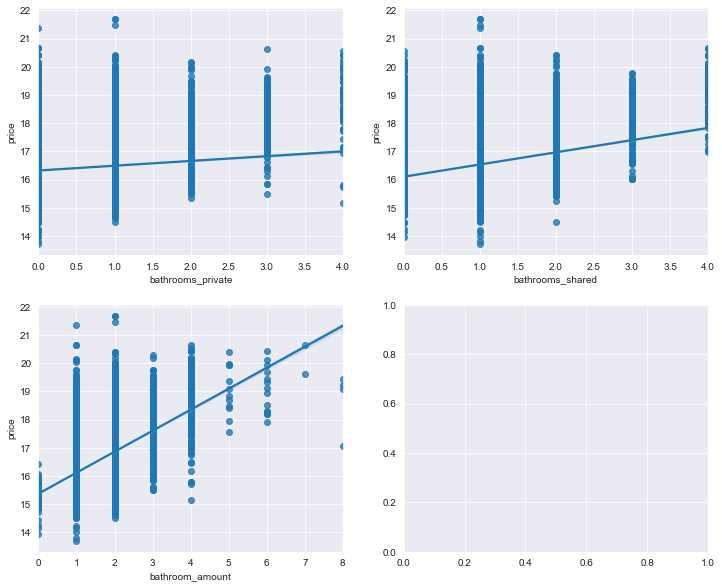

In [37]:
featured = preprocessor.combine_baths(featured.copy())
visualizer.corr_target(featured, cols=["bathrooms_private", "bathrooms_shared", "bathroom_amount"], 
                target='price')
featured = preprocessor.remove_labels(featured.copy(), labels=["bathrooms_private", "bathrooms_shared"])

This shows that combining the two gives a higher correlation to the price than each of them on their own. We will therefore remove the other two, and replace them with this new feature.

We will now turn our head to the windows - namely the *windows_street* and *windows_court* features. They do not do much like they are now, so we will try to combine these into a new categorical feature **has_windows** which describes whether or not an apartment has *none* of the two, just *one*, or *both*. We will have a seperate category for whether it is *unknown*, as a lot of *NaN* values existed in these features, and were replaced by *-1* (unknown).

                windows_street  windows_court  has_windows     price
windows_street        1.000000       0.714756     0.922860  0.042730
windows_court         0.714756       1.000000     0.921665 -0.079195
has_windows           0.922860       0.921665     1.000000  0.000852
price                 0.042730      -0.079195     0.000852  1.000000


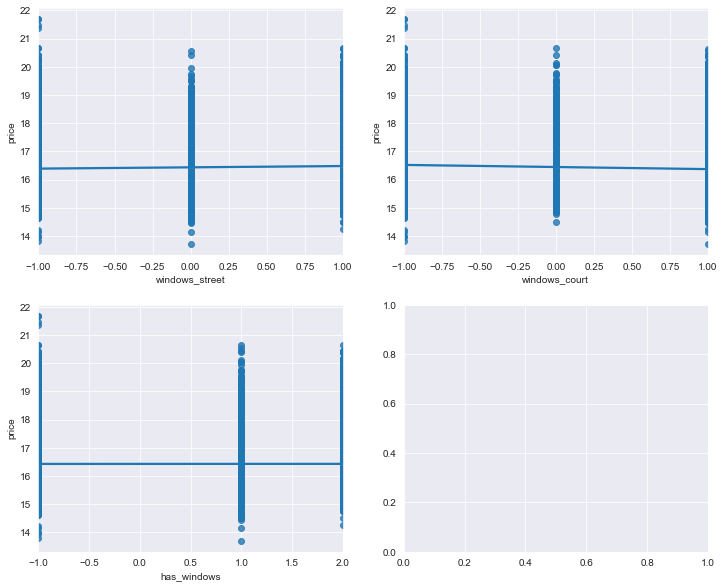

In [38]:
featured = preprocessor.combine_windows(featured.copy())
visualizer.corr_target(featured, cols=["windows_street", "windows_court", "has_windows"], target='price')

This feature does not correlate anything to the price - or at least very minimal. This is not something we want to add to our algorithm. Can we instead of making a categorical feature try to make a boolean one - describing whether or not any of the two types of windows exist? We will look at unknown as *false*.

                windows_street  windows_court  has_windows     price
windows_street        1.000000       0.714756     0.865483  0.042730
windows_court         0.714756       1.000000     0.936012 -0.079195
has_windows           0.865483       0.936012     1.000000 -0.081832
price                 0.042730      -0.079195    -0.081832  1.000000


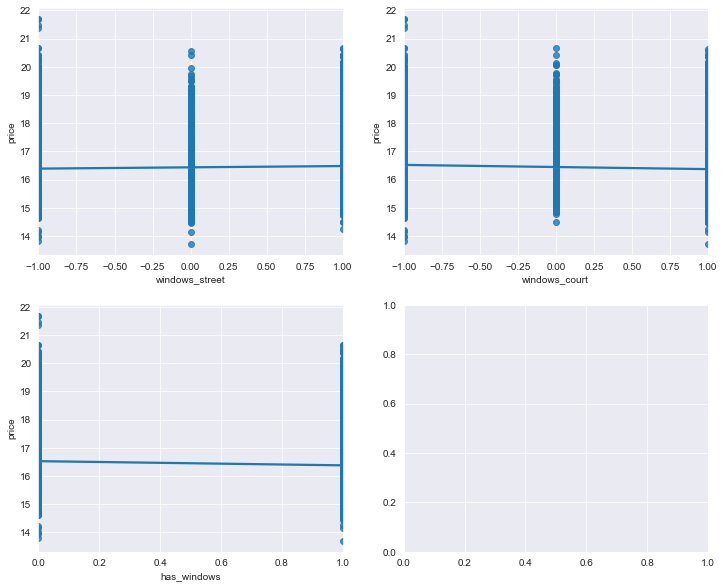

In [39]:
featured = preprocessor.combine_windows(featured.copy(), boolean=True)
visualizer.corr_target(featured, cols=["windows_street", "windows_court", "has_windows"], target='price')

This is better, but it is still a correlation of less than **0.1** to price. All these features are eligable for removal later, but we will leave them for now.

Now lets go over to one we know will have impact. We discussed this earlier when talking about *latitude* and *longitude*. We will now combine these features into a new one - **distance_center**. This will be calculated as the distance in meters to the [*red square*](https://en.wikipedia.org/wiki/Red_Square) in the very heart of Moscow. 

                 latitude  longitude  distance_center     price
latitude         1.000000   0.624006        -0.959930  0.162631
longitude        0.624006   1.000000        -0.499941 -0.067534
distance_center -0.959930  -0.499941         1.000000 -0.528687
price            0.162631  -0.067534        -0.528687  1.000000


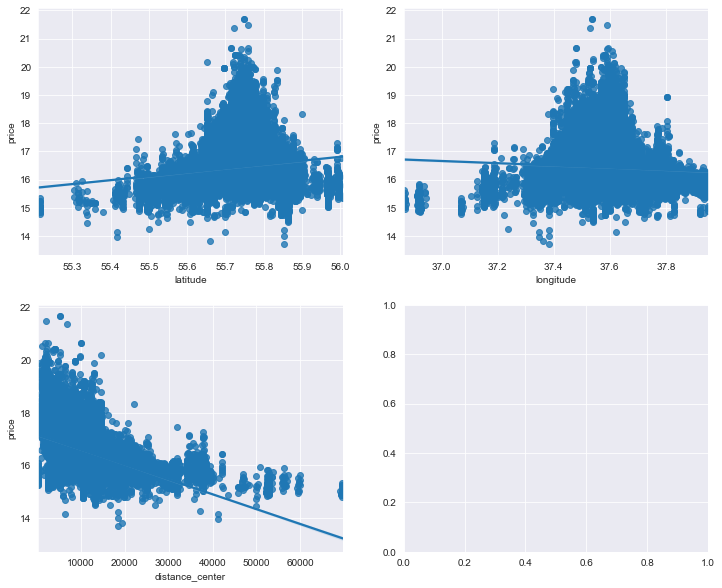

In [40]:
featured = preprocessor.combine_latlon(featured.copy())
visualizer.corr_target(featured, cols=["latitude", "longitude", "distance_center"], target='price')

As we thought. This feature has a very negative correlation to the price - meaning that when the *distance_center* feature is lower, the price gets higher. This, of course, makes sense, as apartments closer to the city center is ofter much more expensive. Lets plot this feature correlating to price.

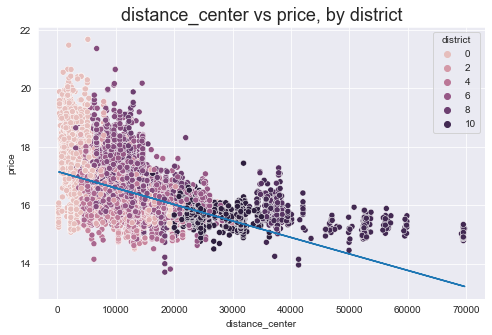

In [41]:
visualizer.plot_vs(featured[:23285].copy(), "distance_center", "price", reg=True, figsize=(8,5), hue="district")

The trend is very clear, and when using the district as the hue, we can clearly see how far the districts are away from the center as well - on a general basis. Lets now plot a new correlation grid to see how far we have come.


We remove the features: *garbage_chute*, *phones*, *has_windows*, *windows_street* and *windows_court*

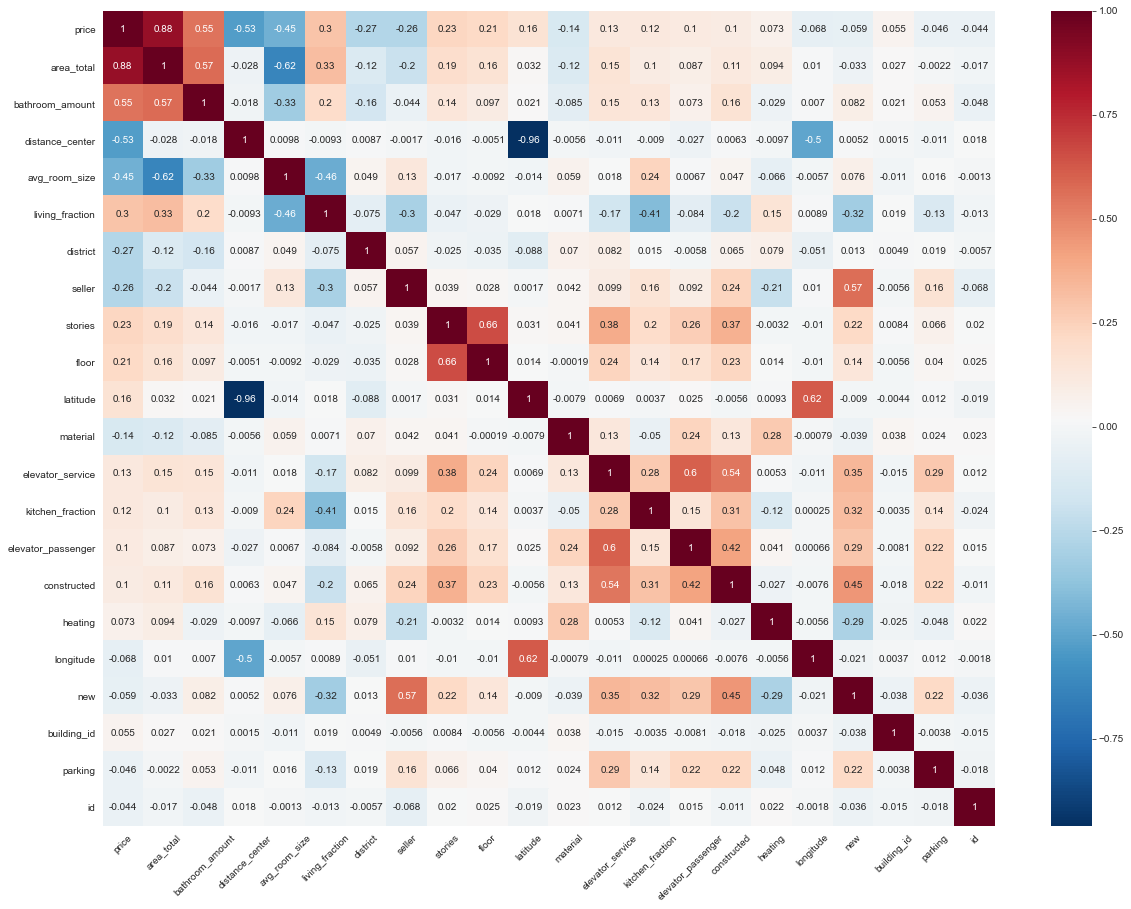

In [42]:
featured = preprocessor.remove_labels(featured.copy(), ["garbage_chute", "phones", "has_windows", "windows_street", "windows_court"])
visualizer.price_correlation(featured)

This has changed a lot. We have fewer features correlating to eachother, and more that correlate to price in a more impactful manner. However, there are a lot of features with below 0.1 correlation to price. We have now remove all those who does neither have a correlation higher than **0.1** to the price, or reasonable correlation to another feature. We do this because those features are not eligable for creating a new feature, nor being standalone.

The next thing we will look at is the elevator features. We will try combine these into a *has_elevator* feature, which, much like the windows, will tell if a building has both types of elevator, just one, or none. 

                    elevator_passenger  elevator_service  has_elevator  \
elevator_passenger            1.000000          0.602908      0.749115   
elevator_service              0.602908          1.000000      0.926986   
has_elevator                  0.749115          0.926986      1.000000   
price                         0.104824          0.125532      0.134552   

                       price  
elevator_passenger  0.104824  
elevator_service    0.125532  
has_elevator        0.134552  
price               1.000000  


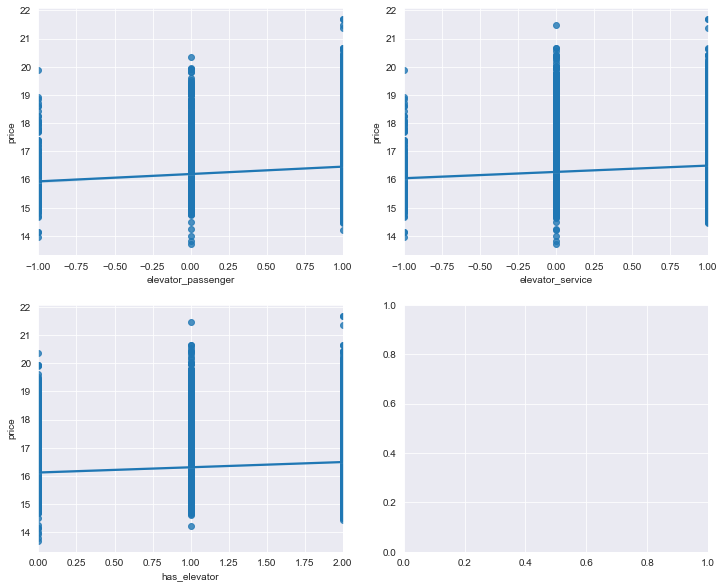

In [43]:
featured = preprocessor.combine_elevators(featured.copy())
visualizer.corr_target(featured, cols=["elevator_passenger", "elevator_service", "has_elevator"], target='price')

This feature does not really do that much, but it combines the two into a feature better than anyone of them on their own. We will remove the two other features and replace it with this, simplifying the data.

In [44]:
featured = preprocessor.remove_labels(featured.copy(), ["elevator_passenger", "elevator_service"])
featured.head()

,id,seller,price,area_total,floor,building_id,new,latitude,longitude,district,constructed,material,stories,parking,heating,avg_room_size,living_fraction,kitchen_fraction,bathroom_amount,distance_center,has_elevator
0,0,3.0,15.781156,4.097672,2.0,4076,1.0,55.544046,37.478055,11.0,2021.0,3.0,9.0,1.0,-1.0,2.048836,0.845782,0.635163,2.0,25022.080164,2
1,1,-1.0,16.166886,4.488636,18.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,0.0,1.496212,0.867038,0.606263,2.0,12267.029455,2
2,2,3.0,16.014916,4.375757,12.0,5176,1.0,55.663299,37.515335,6.0,2021.0,3.0,15.0,1.0,-1.0,1.458586,0.853086,0.721475,2.0,12060.133853,2
3,3,-1.0,16.166886,4.488636,18.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,0.0,1.496212,0.867038,0.603312,2.0,12267.029455,2
4,4,-1.0,16.447399,4.369448,7.0,6604,0.0,55.590785,37.451438,11.0,2017.0,2.0,15.0,1.0,0.0,2.184724,0.820131,0.661496,1.0,21041.782467,2


Now lets look at two features that should correlate a lot - namely *new* and *constructed*. There is no reason having both these in the dataset, as the year of construction should tell us if the apartment is new or not. Let plot these agains each other and have a look.

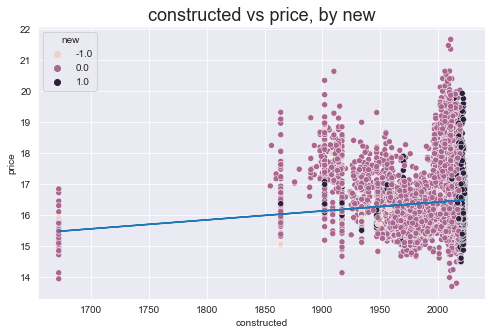

In [45]:
visualizer.plot_vs(featured[:23285].copy(), "constructed", "price", reg=True, figsize=(8,5), hue="new")

This does show something interesting - outliers exist. There are actually multiple apartments constructed before 2000 which as considered new. This is of course wrong. We will alter the *new* feature to be true when the apartment was buildt after 2018, else false. Lets see what this does.

                  new  constructed     price
new          1.000000     0.513370 -0.124977
constructed  0.513370     1.000000  0.103806
price       -0.124977     0.103806  1.000000


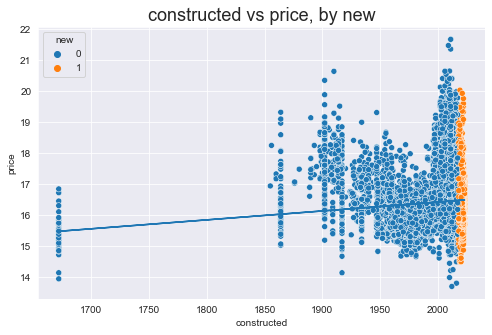

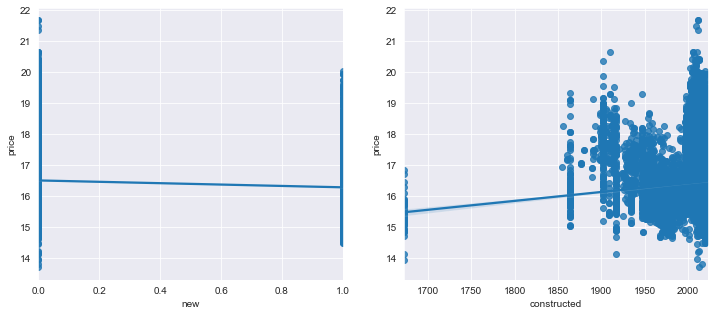

In [46]:
featured = preprocessor.redo_new(featured.copy())
visualizer.plot_vs(featured[:23285].copy(), "constructed", "price", reg=True, figsize=(8,5), hue="new")
visualizer.corr_target(featured, cols=["new", "constructed",], target='price')

This gives a sizable improvement to the *new* feature, but it is of course dependent on the construction year. As we discussed earlier in the exploration phase, the construction year did now really have the impact one might think on the price. When altering the *new* feature based on the actual construction year, we have "merged" these features together. Therefore - we will drop the *constructed* feature, and keep the *new* feature.

Lets once again look at the correlation grid. We will now look further into how can use the new and old features to improve the dataset.

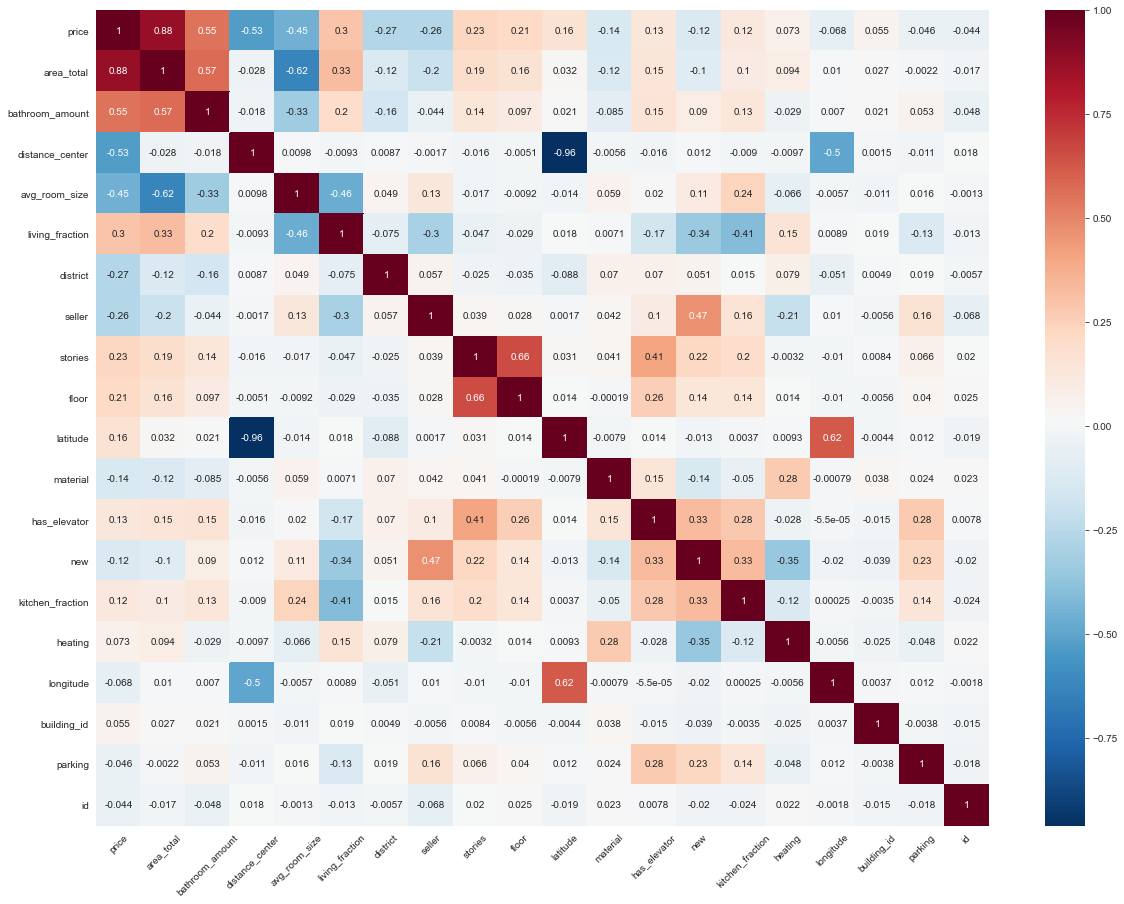

In [47]:
featured = preprocessor.remove_labels(featured.copy(), ["constructed"])
visualizer.price_correlation(featured)

Lets make a strategy.
We see that *heating* is a feature not really correlating to anything. Therefore, we will remove it.<br>
We see that *floor* and *stories* has a very high correlation. We should try to find something to do about this.<br>
We see that the *latitude* is much more impactful than the *longitude* when it comes to both *price* and *distance_center*. We will look into how we either remove *latitude* and/or *longitude*, or if we need to do something else with them.

In [48]:
#featured = preprocessor.remove_labels(featured.copy(), ["heating"])
categorical = preprocessor.split_categorical_features(featured.copy(), ["seller", "district", "material", "has_elevator", "heating"])
print("Number of features so far:", categorical.shape[1])
categorical.head()

Number of features so far: 44


,id,price,area_total,floor,building_id,new,latitude,longitude,stories,parking,avg_room_size,living_fraction,kitchen_fraction,bathroom_amount,distance_center,seller_0.0,seller_1.0,seller_2.0,seller_3.0,district_0.0,district_1.0,district_2.0,district_3.0,district_4.0,district_5.0,district_6.0,district_7.0,district_8.0,district_9.0,district_10.0,district_11.0,material_0.0,material_1.0,material_2.0,material_3.0,material_4.0,material_5.0,material_6.0,has_elevator_1,has_elevator_2,heating_0.0,heating_1.0,heating_2.0,heating_3.0
0,0,15.781156,4.097672,2.0,4076,1,55.544046,37.478055,9.0,1.0,2.048836,0.845782,0.635163,2.0,25022.080164,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0
1,1,16.166886,4.488636,18.0,1893,0,55.861282,37.666647,25.0,1.0,1.496212,0.867038,0.606263,2.0,12267.029455,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
2,2,16.014916,4.375757,12.0,5176,1,55.663299,37.515335,15.0,1.0,1.458586,0.853086,0.721475,2.0,12060.133853,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
3,3,16.166886,4.488636,18.0,1893,0,55.861282,37.666647,25.0,1.0,1.496212,0.867038,0.603312,2.0,12267.029455,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0
4,4,16.447399,4.369448,7.0,6604,0,55.590785,37.451438,15.0,1.0,2.184724,0.820131,0.661496,1.0,21041.782467,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0


## Trying different models

There exists multiple different machine learning models to use for different problems. Which one to choose it not trivial, and often leads to trying different. With trial and error, we will be able to find a model which suits our needs when it comes to the problem at hand. In this section, we will discuss 4 models we have used in this project. We will train them, compare them, and evaluate them, hopefully leading to us finding a model we want to develop further with error analysis and more detailed hyperparameter tuning. 

We will start by seperating the data into training and testing data. Remember that we joined these into the same DataFrame to secure a uniform preprocessing phase. Now, we will split them again. We will also have to remove the price for the training data, adding these into its own *labels* variable. We will also split the training data into actual training and validation data. The validation set will be set to 30% of the training data. All this is done below, before we feed this into the models.

In [53]:
# Seperating training and test data
train_data = categorical[:23285].copy()
labels = train_data["price"]
test_data = categorical[23285:].copy()
test_data.drop("price", 1, inplace=True)
print("Split data into train and test")

# Splitting training data into training and validation, removed the price for each of them afterwards
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, stratify=train_data.price.round(), test_size=0.3)
x_train.drop("price", 1, inplace=True)
x_test.drop("price", 1, inplace=True)
x_train.drop("id", 1, inplace=True)
x_test.drop("id", 1, inplace=True)
x_train.drop("building_id", 1, inplace=True)
x_test.drop("building_id", 1, inplace=True)
print("Validation data created and price dropped")
print("The number of features are now:", x_train.shape[1])

# Initializing general model
general_model = TestModel(x_train, y_train)
test_labels = np.round([np.expm1(lab)for lab in y_test])

Split data into train and test
Validation data created and price dropped
The number of features are now: 41


### MLP

We start this section by discussing the first model we tried at the start of this project - namely the ***MLP*** model by using *KerasRegressor*.

In [54]:
mlp_model = general_model.keras_mlp_model(epochs=20, batch_size=10, verbose=1)
print("Training MLP model...")
pipeline_mlp = mlp_model.fit(x_train, y_train)
test_pred_mlp = np.round([np.expm1(pred) for pred in mlp_model.predict(x_test)])
print("Training complete \n")
print("RMLSE for MLP model: %s" % general_model.root_mean_squared_log_error(test_labels, test_pred_mlp))

Training MLP model...
Epoch 1/20
1630/1630 [==============================] - 1s 437us/step - loss: 0.0704
Epoch 2/20
1630/1630 [==============================] - 1s 433us/step - loss: 0.0262
Epoch 3/20
1630/1630 [==============================] - 1s 439us/step - loss: 0.0221
Epoch 4/20
1630/1630 [==============================] - 1s 429us/step - loss: 0.0203
Epoch 5/20
1630/1630 [==============================] - 1s 437us/step - loss: 0.0186
Epoch 6/20
1630/1630 [==============================] - 1s 449us/step - loss: 0.0179
Epoch 7/20
1630/1630 [==============================] - 1s 436us/step - loss: 0.0169
Epoch 8/20
1630/1630 [==============================] - 1s 430us/step - loss: 0.0160
Epoch 9/20
1630/1630 [==============================] - 1s 425us/step - loss: 0.0156
Epoch 10/20
1630/1630 [==============================] - 1s 427us/step - loss: 0.0150
Epoch 11/20
1630/1630 [==============================] - 1s 431us/step - loss: 0.0146
Epoch 12/20
1630/1630 [==================

This initial MLP model with layers structured as this: **64, 128, 128, 64, 1**. Where each number represents the number of nodes in each network gives a RMSLE far below what we want on the validation set. This is of course with no hyperparameter tuning. Lets plot the predictions and the actual labels on the same graph and discuss what we see.

Mean error for MLP model: 5559498.274835385 rubels


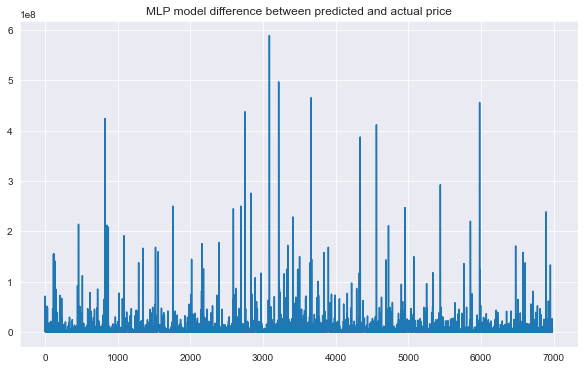

In [55]:
mlp_diff = abs(test_pred_mlp - test_labels)
print("Mean error for MLP model:", mlp_diff.mean(), "rubels")
visualizer.error_plot(mlp_diff, "MLP difference between predicted and actual price")

Keep in mind that the models might be slightly different when changing the train and validation split. This is because it not train on the same data as last time. It should, however, stay around the same area, making it possible to generalize. 

We see that the mean error - the actual mean price difference between the predictions and the labels - is very high, leading to a high RMSLE as well. If the number is positive, it means that this model overestimates the price, guessing it is worth more than it actually is, and vice versa. In these graphs, we will use absolute value to find out how large difference is, ignoring if it is negative or positive. We will not try to futher improve the *MLP* model, as it does not perform well enough for us to use more time on it. 

Lets instead turn our heads towards another model - namely *RandomForest*.

### RandomForest

We will not be using tuned hyperparameters for this one either. **RandomForest** is notorious for overfitting, and we will be cautious of this when tuning models. This snippet is just to see if the base model itself will preform better than the previous *MLP* model.

In [56]:
rf_model = general_model.randomforest_model()
print("Training RF model...")
pipeline_rf = rf_model.fit(x_train, y_train)
test_pred_rf = np.round([np.expm1(pred) for pred in rf_model.predict(x_test)])
print("Training complete \n")
print("RMLSE for RF model: %s" % general_model.root_mean_squared_log_error(test_labels, test_pred_rf))

Training RF model...
Training complete 

RMLSE for RF model: 0.1661146034221112


Needless to say, this looks much more promising than with *MLP*. Keep in mind that this is without any hyperparameter tuning - just a clean constructor with default values. Lets again plot the difference and discuss it.

Mean error for RF model: 3904953.431004867 rubels


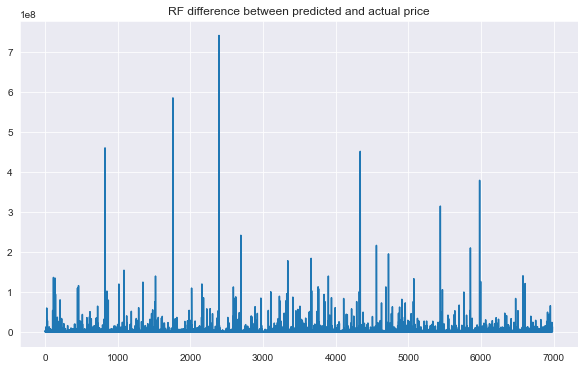

In [57]:
rf_diff = abs(test_pred_rf - test_labels)
print("Mean error for RF model:", rf_diff.mean(), "rubels")
visualizer.error_plot(rf_diff, "RF difference between predicted and actual price")

We see that the mean error for this model is lower - which is good. It has a significantly lower RMSLE, which makes sense. Because of this good initial score, we will keep the RandomForest model fresh in our minds when it comes to tuning the model even more.

Lets continue with **XGBoost**

### XGBoost

XGBoost is a model which is known for being very sensitive to hyperparameter tuning. This means that the success of a model might be vastly different depending on the hyperparameters provided in the constructor. We will, once again, just use the base model for this simple comparison - getting an idea of where this model lies when it comes to out dataset.

In [58]:
boost_model = general_model.xgboost_model()
print("Training XGBoost model...")
pipeline_boost = boost_model.fit(x_train, y_train)
test_pred_boost = np.round([np.expm1(pred) for pred in boost_model.predict(x_test)])
print("Training complete \n")
print("RMLSE for XGBoost model: %s" % general_model.root_mean_squared_log_error(test_labels, test_pred_boost))

Training XGBoost model...
Training complete 

RMLSE for XGBoost model: 0.15865437714338324


Not bad. It performs around the same as *RandomForest* does, making it worth tuning later on. Lets plot the data.

Mean error for RF model: 3755299.2097051246 rubels


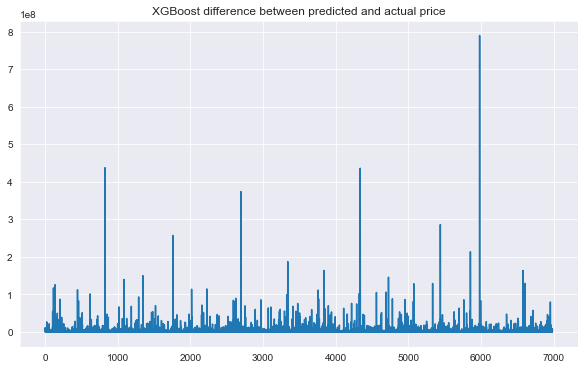

In [59]:
boost_diff = abs(test_pred_boost - test_labels)
print("Mean error for RF model:", boost_diff.mean(), "rubels")
visualizer.error_plot(boost_diff, "XGBoost difference between predicted and actual price")

It seems like *XGBoost* and *RandomForest* has something else in common. They seem to predict very wrong on the same apartments. These graphs are almost exactly the same. We have to look into what is so special about these apartments. For now though, we will look at tuning both *RandomForest* and *XGBoost*, but will not think any more about the *MLP* model.

Lets finish the initial trial of models by testing the **LGBM** model.

### LGBM

*LightGBM* was developed by microsoft as a alternative model for solving machine learning problems. We will once again try the default constructor to see if it can be a contender for helping us accieve the goal of finding the best predictions for houses and apartments in Moscow.

In [60]:
lgbm_model = general_model.lgbm_model()
print("Training LGBM model...")
pipeline_lgbm = lgbm_model.fit(x_train, y_train)
test_pred_lgbm = np.round([np.expm1(pred) for pred in lgbm_model.predict(x_test)])
print("Training complete \n")
print("RMLSE for LGBM model: %s" % general_model.root_mean_squared_log_error(test_labels, test_pred_lgbm))

Training LGBM model...
Training complete 

RMLSE for LGBM model: 0.17613274406161114


This RMSLE is obviously lower than both *RF* and *XGBoost*, but still, not that bad. We have to keep in mind that we have not done any tuning, but just used the standard constructor. We think this value is good enough for developing the model further, and it is still in the running. Lets plot the data and see what it shows us.

Mean error for RF model: 4460610.419696536 rubels


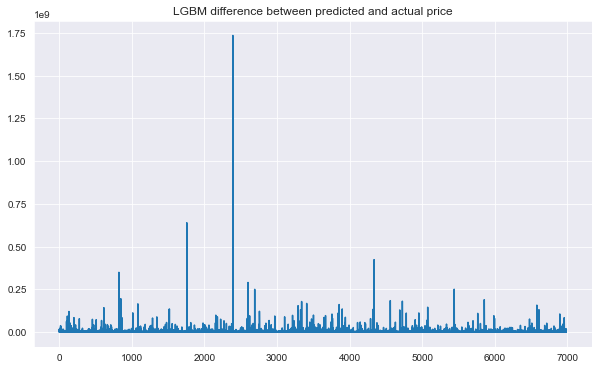

In [61]:
lgbm_diff = abs(test_pred_lgbm - test_labels)
print("Mean error for RF model:", lgbm_diff.mean(), "rubels")
visualizer.error_plot(lgbm_diff, "LGBM difference between predicted and actual price")

We see that this model has a larger mean error than the other two - which is also reflected in the RMSLE. This comes from the huge spikes in error. As we discussed earlier, we will have to look at the apartments the models are very wrong about, and what makes them special. We believe that LGBM is good enough for now to keep.

Now, lets go over to tuning some parameters

## Tuning hyperparameters

In this section, we will come back to the models we used in the previous section. We will use *GridSearchCV*, to feed the models different ranges of hyperparameters to try, and return the best combination of these. This process will take time. Because of this, we have created files for each of the models you can load the best configuration from if you want. If not, you are free to run the actual search yourself. To load from file, just put `load=True` as a parameter into the `start_xxx_search` function calls.

### AutoML

Later in this notebook, we will discuss AutoML and how we used it to find models for solving the problem. We will combine and compare the models discussed above, but also some other popular choices when it comes to these sorts of problems. Finding the best model with AutoML takes a lot more time than just running the models straigt up (as we have up until this point). We will discuss AutoML in the last part of this section, and it might be the way we go when it comes to choosing the models and hyperparameters

### RandomForest hyperparameter search

*RandomForest* is a model where hyperparameters are very important. Because of this, we will create a grid with a fair amount of different parameters, making the probability of finding a good model higher, but using more time. Below you can see the parameter grid we will be using for this model.


In [62]:
params_rf = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 150, 200, 220, 240, 260, 300, 320, 350]}

This will lead to `2 * 11 * 2 * 3 * 3 * 10 = 3960` different candidates of the *RandomForest* model - which would take ages if we were to to it manually. Lets start the search (keep in mind you can use `load=True` to load the best one from file).

In [70]:
rf_search = general_model.start_rf_search(params_rf, load=True)
rf_best = rf_search.fit(x_train, y_train)
rf_best

{'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


RandomForestRegressor(bootstrap=False, max_depth=30, max_features='sqrt',
                      n_estimators=300)

### XGBoost hyperparameter search

*XGBoost* is a another model where hyperparameters are very important. We use the same way to search the parameter grid, but of course, with new parameters.

In [73]:
params_boost = {'nthread':[4],
              'objective':['reg:squarederror'],
              'learning_rate': [.05, .14, .2, .3],
              'max_depth': [3, 4, 5, 6],
              'min_child_weight': [1, 2, 4, 6],
              'subsample': [.7, 1, .6, .5],
              'colsample_bytree': [.7, .5, 0.3],
              'n_estimators': [50, 100, 200, 300, 500]}

This will lead to `1 * 1 * 4 * 4 * 4 * 4 * 3 * 5 = 3840` different candidates of the *XGBoost* model. You can start the search below.

In [74]:
boost_search = general_model.start_xgboost_search(params_boost, load=True)
boost_best = boost_search.fit(x_train, y_train)
boost_best

XGBRFRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bytree=0.7, gamma=0, gpu_id=-1, importance_type='gain',
               interaction_constraints='', learning_rate=0.14, max_delta_step=0,
               max_depth=6, min_child_weight=1, missing=nan,
               monotone_constraints='()', n_estimators=500, n_jobs=4, nthread=4,
               num_parallel_tree=500, objective='reg:squarederror',
               random_state=0, reg_alpha=0, scale_pos_weight=1, subsample=0.6,
               tree_method='exact', validate_parameters=1, verbosity=None)

### LGBM hyperparameter search

We do the same thing as with the other two, but this time on the *LGBM* model.

In [82]:
params_lgbm = {
    'learning_rate': [0.005, 0.01, 0.003],
    'n_estimators': [50, 100, 200, 500, 1000],
    'num_leaves': [6, 8, 12, 16],
    'boosting_type' : ['gbdt', 'dart', 'goss'],
    'objective': ['regression'],
    'metric': ['rmse'],
    'colsample_bytree' : [0.5, 0.6],
    'subsample' : [0.7, 0.75],
    'reg_alpha' : [1, 1.2],
    'reg_lambda' : [1, 1.2, 1.4]}

This will lead to `3 * 5 * 4 * 3 * 1 * 1 * 2 * 2 * 2 * 3 = 4320` different candidates of the *LGBM* model. 

In [84]:
lgbm_search = general_model.start_lgbm_search(params_lgbm, load=True)
lgbm_best = lgbm_search.fit(x_train, y_train)
lgbm_best

LGBMRegressor(boosting_type='goss', colsample_bytree=0.6, learning_rate=0.01,
              metric='rmse', n_estimators=1000, num_leaves=16,
              objective='regression', reg_alpha=1, reg_lambda=1, subsample=0.7)

### AutoML

*GridSearchCV* can be a very nice way of finding good hyperparameters for a model. Another way of doing this is to use something called **AutoML**. These kinds of algoritms will automatically try different models and tune them for the problem. It will run a set amount of time, or until it converges, and return the best model it found during execution. Keep in mind that this is based on training loss, which can be significantly less than the validation and test loss. We will run Microsofts AutoML algorithm *flaml*, and tell it to try the three different models discussed above. Maybe it will be able to find something better than we already have. After this, we will analyze the error to see where our algorithm is guessing wrong. Maybe some features are too influential, or not influencial enough? 

In [85]:
general_model.autoMLfit(x_train, y_train, time=60)

[flaml.automl: 11-16 19:11:30] {1485} INFO - Data split method: uniform
[flaml.automl: 11-16 19:11:30] {1489} INFO - Evaluation method: holdout
[flaml.automl: 11-16 19:11:30] {1540} INFO - Minimizing error metric: customized metric
[flaml.automl: 11-16 19:11:30] {1577} INFO - List of ML learners in AutoML Run: ['xgboost', 'lgbm', 'rf']
[flaml.automl: 11-16 19:11:30] {1826} INFO - iteration 0, current learner xgboost
[flaml.automl: 11-16 19:11:30] {1943} INFO - Estimated sufficient time budget=390s. Estimated necessary time budget=0s.
[flaml.automl: 11-16 19:11:30] {2023} INFO -  at 0.2s,	estimator xgboost's best error=0.9146,	best estimator xgboost's best error=0.9146
[flaml.automl: 11-16 19:11:30] {1826} INFO - iteration 1, current learner lgbm
[flaml.automl: 11-16 19:11:30] {2023} INFO -  at 0.2s,	estimator lgbm's best error=0.0361,	best estimator lgbm's best error=0.0361
[flaml.automl: 11-16 19:11:30] {1826} INFO - iteration 2, current learner lgbm
[flaml.automl: 11-16 19:11:30] {20

In [86]:
test_pred_auto = np.round([np.expm1(pred) for pred in general_model.autoMLpredict(x_test)])
test_labels = np.round([np.expm1(lab)for lab in y_test])

auto_df = pd.DataFrame([(test_labels[i], test_pred_auto[i]) for i in range(len(test_pred_auto))], columns=["actual", "prediction"])
print("RMSLE for AutoML model: %s\n" % general_model.root_mean_squared_log_error(test_labels, test_pred_auto))
general_model.autoML_print_best_model()

RMSLE for AutoML model: 0.1535134196599185

best model lgbm
configs {'n_estimators': 4042, 'num_leaves': 4, 'min_child_samples': 3, 'learning_rate': 0.06912599579706752, 'log_max_bin': 10, 'colsample_bytree': 0.5745736406189523, 'reg_alpha': 0.0015013670204112389, 'reg_lambda': 0.1604443905976729}


As we can see, *AutoML* tries a lot of models quickly. To get the most out if this, we should let it run for some time. This way, the probability of it finding a better model increases. 

Even though we have added, altered and removed features to the dataset - this part of the work it not done. We will now have a second go at feature engineering, mainly focusing on the distance to different landmarks, hospitals, schools and more around moscow. Our idea is that this should make the model better, as real estate is all about: *Location! Location! Location*. Before we do this however, lets see on what kind of aparments the best model *AutoML* found erred the most. This will help us in understanding where we need to finetune the model to get the best result possible.

## Analyzing the error

In this section we will dive into and try to find out where our models go wrong. Getting the price perfect for all the aparments is a utopian dream, and is of course not practically possible. However, we should be able to get a better result than we already have. For this, we need to analyze the error. We will try to find out the kind of apartments our model overestimates, and underestimates, and what they have in common. This will make it possible for us to find out if the features we have created behaves the way we want, or if they are silently hurting the performance. Lets start by plotting the mean error for the best *AutoMl* model.

Mean error for AutoML model: 3885586.700065062 rubels


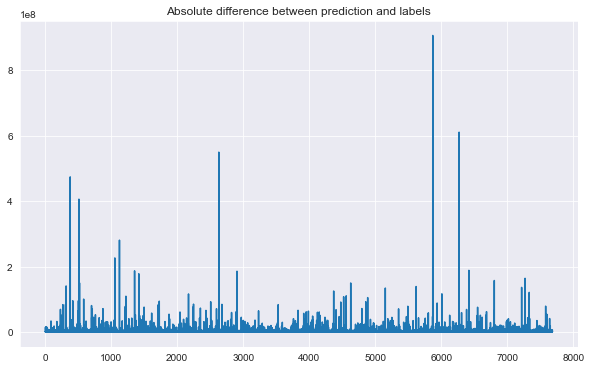

In [87]:
auto_diff = abs(test_pred_auto - test_labels)
print("Mean error for AutoML model:", auto_diff.mean(), "rubels")
visualizer.error_plot(auto_diff, "Absolute difference between prediction and labels")

Once again we see tall spikes, meaning that the model was far off. For one of these, the model missed by around *600 million* rubels, which is way too much to get the performance we want. Lets plot the actual error(not absolute value) to see if we can discover something

Mean actual error: -393763.8930383865


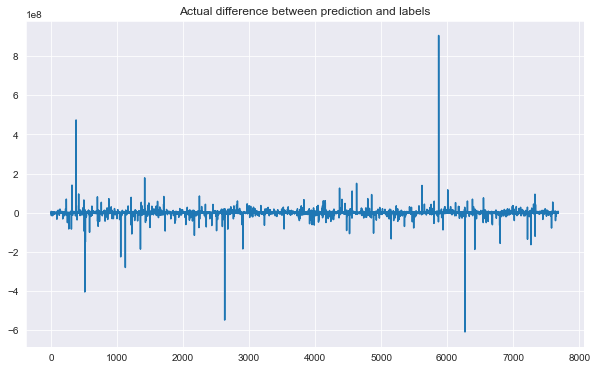

In [88]:
diff = test_pred_auto - test_labels
print("Mean actual error:", diff.mean())
visualizer.error_plot(diff, "Actual difference between prediction and labels")

This shows us that the model does not only guess wrong "one way". It both over- and underestimates apartments. If the mean difference is negative, it means that it it more likely to underestimate ***or*** it underestimates a lot when it does so. Lets see how the model predicts the very expensive, middle, and very cheap apartments. The extremes on both sides can have a huge effect on performance, and we want to perform well across all price ranges.

We will start by finding the top 95%, low 95%, and those between the 45th and 55th percentile. For this, we will only use apartments from the training data - as we want to see the prices and how we predict them.

In [89]:
top_95 = train_data["price"].quantile(0.95)
low_5  = train_data["price"].quantile(0.05)
mid_45 = train_data["price"].quantile(0.45)
mid_55 = train_data["price"].quantile(0.55)

top = train_data[train_data["price"] > top_95]
low = train_data[train_data["price"] < low_5]
mid_temp = train_data[train_data["price"] > mid_45]
mid = mid_temp[mid_temp["price"] < mid_55]

top_mean = np.round(np.expm1(top["price"]).mean())
mid_mean = np.round(np.expm1(mid["price"]).mean())
low_mean = np.round(np.expm1(low["price"]).mean())
                    
print("Mean price top 95%:", top_mean, "rubels")
print("Mean price mid 10%:", mid_mean, "rubels")
print("Mean price low  5%:", low_mean, "rubels")
top_labels = top["price"]
mid_labels = mid["price"]
low_labels = low["price"]

top = preprocessor.remove_labels(top.copy(), "price")
mid = preprocessor.remove_labels(mid.copy(), "price")
low = preprocessor.remove_labels(low.copy(), "price")

Mean price top 95%: 170380311.0 rubels
Mean price mid 10%: 10681944.0 rubels
Mean price low  5%: 4294333.0 rubels


Lets feed these into the model and see how it predicts the prices for these apartments.

In [90]:
# Top
test_pred_top = np.round([np.expm1(pred) for pred in general_model.autoMLpredict(top)])
test_labels_top = np.round([np.expm1(lab)for lab in top_labels])

# Mid
test_pred_mid = np.round([np.expm1(pred) for pred in general_model.autoMLpredict(mid)])
test_labels_mid = np.round([np.expm1(lab)for lab in mid_labels])

# Low
test_pred_low = np.round([np.expm1(pred) for pred in general_model.autoMLpredict(low)])
test_labels_low = np.round([np.expm1(lab)for lab in low_labels])

print("RMSLE TOP: %s" % general_model.root_mean_squared_log_error(test_labels_top, test_pred_top))
print("RMSLE MID: %s" % general_model.root_mean_squared_log_error(test_labels_mid, test_pred_mid))
print("RMSLE LOW: %s" % general_model.root_mean_squared_log_error(test_labels_low, test_pred_low))

RMSLE TOP: 0.23462628458045723
RMSLE MID: 0.10531576175406913
RMSLE LOW: 0.15686967953064537


Mean error on top 95%: -11245280.0 rubels
Mean absolute error on top 95%: 29784442.0 rubels
The error is 0.1748 times the mean price


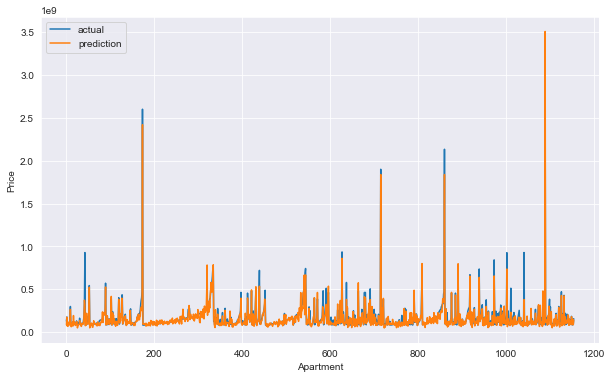

In [91]:
top_df = pd.DataFrame({ "actual": test_labels_top, "prediction": test_pred_top}, index=range(0, 1155))
top_df.plot(ax=plt.gca(), figsize=(10, 6), ylabel="Price", xlabel="Apartment")
top_diff = test_pred_top - test_labels_top
print(f"Mean error on top 95%: {np.round(top_diff.mean())} rubels")
print(f"Mean absolute error on top 95%:", np.round(abs(test_pred_top - test_labels_top).mean()), "rubels")
print(f"The error is {np.round(abs(test_pred_top - test_labels_top).mean()/top_mean, 4)} times the mean price")

This shows that for the top 95% of apartments, we are underestimating the price by an average in the tens of millions. We see that for the apartments in the lower part of this percentile, the prediction seems to not be so bad. We can view this by changing the y-axis to give us a more detailed overview.

<AxesSubplot:xlabel='Apartment', ylabel='Price'>

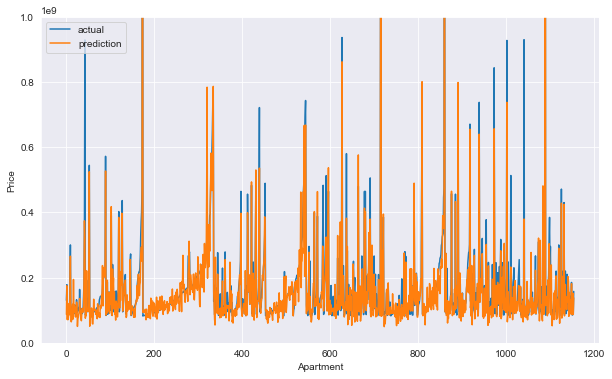

In [92]:
top_df.plot(ax=plt.gca(), figsize=(10, 6), ylabel="Price", xlabel="Apartment", ylim=(0, 1000000000))

This shows more detail. We can see that the predictions are not so bad. There are still places where the model predicts way more, or way less than it should, but for the most part, it seems like it is doing OK. We saw in the last graph (which is this one, it just has the y-axis limited) that the model on average underestimates the price for these expensive apartments. This also seems to be the case for these lower-end high-end apartments. We see a lot of blue above the orange, meaning that the prediction did not reach the actual price. Lets find the top 5% of apartments where the erred the most and see what they are like.

In [93]:
top_error = top_df.copy()
top_error["id"] = list(top["id"])
top_error["diff"] = abs(top_error["prediction"] - top_error["actual"])
top_error = top_error[top_error["diff"] > top_error["diff"].quantile(0.95)]
print("Amount:", len(top_error))
top_error.head()

Amount: 58


,actual,prediction,id,diff
16,100000000.0,194204690.0,880,94204690.0
42,928585500.0,317863411.0,2468,610722089.0
127,436050000.0,310653332.0,3060,125396668.0
146,272385080.0,152113993.0,3102,120271087.0
171,402387050.0,293425827.0,3157,108961223.0


In [94]:
unlogged = data.copy()
unlogged["price"] = np.expm1(unlogged["price"])
unlogged["area_total"] = np.expm1(unlogged["area_total"])
misfits_top = pd.DataFrame()
for _, row in top_error.iterrows():
    frame = pd.DataFrame(unlogged[unlogged["id"] == row["id"]])
    frame["prediction"] = row["prediction"]
    misfits_top = pd.concat([misfits_top, frame])
print("Amount:", len(misfits_top))
misfits_top

Amount: 58


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating,prediction
880,880,-1.0,1.000000e+08,471.00,4.580132,5.559899,29.0,6.0,1.0,0.0,-1.0,-1.0,0.0,6411,0.0,55.808260,37.448276,8.0,2011.0,2.0,28.0,1.0,1.0,0.0,-1.0,0.0,1.942047e+08
2468,2468,-1.0,9.285855e+08,750.00,5.041526,6.023681,15.0,6.0,1.0,0.0,-1.0,-1.0,1.0,5410,0.0,55.713725,37.479061,7.0,2006.0,2.0,15.0,1.0,0.0,-1.0,-1.0,0.0,3.178634e+08
3060,3060,-1.0,4.360500e+08,306.00,4.154373,5.130699,7.0,5.0,4.0,0.0,-1.0,-1.0,1.0,3979,0.0,55.741130,37.577597,0.0,1902.0,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,3.106533e+08
3102,3102,-1.0,2.723851e+08,158.00,3.044522,4.709530,3.0,3.0,2.0,0.0,1.0,1.0,2.0,3451,0.0,55.737314,37.600891,0.0,2006.0,0.0,6.0,1.0,1.0,0.0,-1.0,0.0,1.521140e+08
3157,3157,-1.0,4.023871e+08,311.00,3.258097,5.442418,3.0,5.0,4.0,0.0,1.0,1.0,2.0,6966,0.0,55.721863,37.571390,0.0,2015.0,-1.0,8.0,0.0,1.0,0.0,1.0,0.0,2.934258e+08
3158,3158,-1.0,4.766739e+08,303.00,2.397895,5.278115,8.0,4.0,2.0,0.0,1.0,1.0,2.0,7204,0.0,55.764171,37.599094,0.0,2006.0,2.0,8.0,1.0,0.0,0.0,-1.0,0.0,2.503188e+08
3217,3217,-1.0,2.600000e+09,2181.00,6.104741,7.089557,95.0,6.0,1.0,1.0,-1.0,-1.0,1.0,5745,0.0,55.749511,37.537083,0.0,2011.0,2.0,95.0,1.0,1.0,0.0,1.0,0.0,2.419172e+09
3490,3490,-1.0,1.547643e+08,278.00,4.059989,5.035331,6.0,5.0,4.0,0.0,1.0,1.0,2.0,7528,0.0,55.745554,37.595573,0.0,1998.0,2.0,7.0,1.0,0.0,0.0,-1.0,0.0,2.681724e+08
3528,3528,-1.0,2.166700e+08,134.00,3.348574,4.312514,11.0,2.0,1.0,1.0,-1.0,-1.0,1.0,746,0.0,55.765412,37.591773,0.0,2002.0,2.0,12.0,1.0,0.0,-1.0,-1.0,-1.0,1.159362e+08
3529,3529,-1.0,2.190000e+08,152.00,3.397858,4.178992,4.0,3.0,1.0,0.0,-1.0,-1.0,1.0,1621,0.0,55.761983,37.614213,0.0,2007.0,0.0,6.0,1.0,0.0,-1.0,-1.0,0.0,1.106895e+08


Okay. These are the top 58 of the top 95% (based on price) the model missed the most. We can see that most of them are large - which makes sense as these are the expensive ones. We also see that most of them are located in district 0, which is the one closest to the city center. Most of them also have multiple bathrooms, which makes sense for a large apartment. Lets try finding if there are some anomalies hiding here.

We have already discovered that the model more often than not underestimates the price of these expensive apartments. Why is that?

We see that the model things large apartments (houses) in the outside districts (far away from the center) are worth more than they actually are - and the opposite for large ones in the city core. It seems like it cares too much about how large the apartment is, and less where it is located. We can confirm this when looking at the correlation grid, where *area_total* is around *0.88* while *distance_center* is around *-0.53*. As stated earlier, real estate is "all about" location - and because of this, having just one distance feature seems to not do the trick for us. 

In this DataFrame we also see that apartments higher up in the buildings (penthouses) are usually worth significantly more than the model believes. This correlation between *floor* and *stories* is something we have touched on earlier, but it seems like we need to come back to the drawing board for this, as it will help sorting these errors out. 

Keeping this in mind, we will now look for anomalies in the low sector in our dataset. This part performed better than the top. This can be because the possible error for these are lower than the expensive ones (as the apartments are only worth so much), but we will se if we can find some systematic weirdness.

Mean error on low 95%: 300136.0 rubels
Mean absolute error on low 95%: 472083.0 rubels
The error is 0.1099 times the mean price


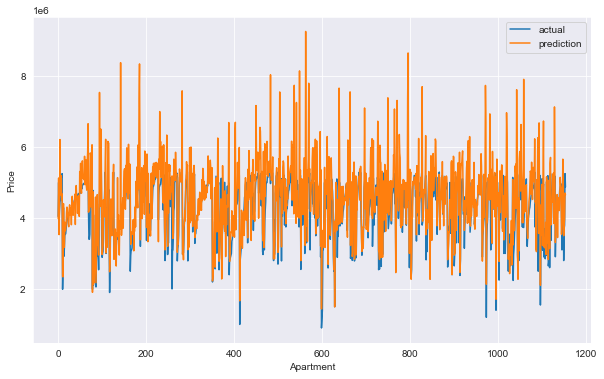

In [95]:
low_df = pd.DataFrame({ "actual": test_labels_low, "prediction": test_pred_low}, index=range(0, 1155))
low_df.plot(ax=plt.gca(), figsize=(10, 6), ylabel="Price", xlabel="Apartment")
low_diff = test_pred_low - test_labels_low
print(f"Mean error on low 95%: {np.round(low_diff.mean())} rubels")
print(f"Mean absolute error on low 95%:", np.round(abs(test_pred_low - test_labels_low).mean()), "rubels")
print(f"The error is {np.round(abs(test_pred_low - test_labels_low).mean()/low_mean, 4)} times the mean price")

This shows that for the lowest 5% of apartments, we are overestimating the price by an average in in the hundreds of thousands. This number is not that high, but we have to keep in mind that the prices are also lower. Many of these apartments cost less than the error we have for the higher end apartments. We also see that the error relative to the mean price of the set is lower than with the higher end apartments. We can be quite certain that the current model will perform better on lower end apartments than higher end ones. Lets look for anomalies.

In [96]:
low_error = low_df.copy()
low_error["id"] = list(low["id"])
low_error["diff"] = abs(low_error["prediction"] - low_error["actual"])
low_error = low_error[low_error["diff"] > low_error["diff"].quantile(0.95)]
print("Amount:", len(low_error))
low_error.head()

Amount: 58


,actual,prediction,id,diff
4,4450000.0,6209961.0,29,1759961.0
94,4700000.0,7538015.0,1723,2838015.0
108,4600000.0,6217094.0,2110,1617094.0
113,4300000.0,6158456.0,2145,1858456.0
114,4500000.0,6109875.0,2146,1609875.0


In [97]:
misfits_low = pd.DataFrame()
for _, row in low_error.iterrows():
    frame = pd.DataFrame(unlogged[unlogged["id"] == row["id"]])
    frame["prediction"] = row["prediction"]
    misfits_low = pd.concat([misfits_low, frame])
print("Amount:", len(misfits_low))
misfits_low

Amount: 58


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating,prediction
29,29,-1.0,4450000.0,50.20,2.484907,3.583519,1.0,2.0,1.0,1.0,1.0,0.0,1.0,7904,0.0,55.580508,37.159207,11.0,2019.0,-1.0,3.0,0.0,0.0,1.0,0.0,-1.0,6209961.0
1723,1723,-1.0,4700000.0,38.00,2.173360,3.085552,10.0,2.0,0.0,1.0,-1.0,-1.0,0.0,3594,-1.0,55.848913,37.586356,2.0,1956.0,-1.0,16.0,-1.0,-1.0,-1.0,-1.0,-1.0,7538015.0
2110,2110,1.0,4600000.0,39.00,2.196414,3.465736,13.0,2.0,0.0,2.0,1.0,0.0,1.0,1158,0.0,55.849221,37.586607,2.0,1980.0,-1.0,17.0,1.0,1.0,1.0,-1.0,-1.0,6217094.0
2145,2145,2.0,4300000.0,30.00,1.966865,2.861278,7.0,1.0,0.0,1.0,1.0,0.0,2.0,7102,1.0,55.889200,37.590973,2.0,2020.0,2.0,15.0,1.0,0.0,0.0,-1.0,-1.0,6158456.0
2146,2146,1.0,4500000.0,38.00,2.173360,3.044522,10.0,2.0,0.0,1.0,-1.0,-1.0,1.0,1158,0.0,55.849221,37.586607,2.0,1980.0,-1.0,17.0,1.0,1.0,1.0,-1.0,-1.0,6109875.0
2241,2241,1.0,3500000.0,75.00,2.564949,3.737670,2.0,3.0,0.0,1.0,-1.0,-1.0,1.0,9053,1.0,55.506250,37.569557,11.0,1968.0,-1.0,5.0,-1.0,-1.0,-1.0,-1.0,-1.0,5137465.0
2248,2248,1.0,3950000.0,45.00,1.945910,3.433987,2.0,2.0,0.0,1.0,1.0,0.0,1.0,6854,0.0,55.785549,37.613575,2.0,1973.0,3.0,5.0,0.0,0.0,-1.0,-1.0,0.0,8376639.0
2319,2319,0.0,2500000.0,45.00,2.397895,3.258097,1.0,2.0,0.0,1.0,1.0,0.0,2.0,6674,0.0,55.524289,37.222520,10.0,1672.0,0.0,1.0,0.0,0.0,1.0,-1.0,-1.0,4657454.0
2339,2339,0.0,5050000.0,73.00,2.770130,3.716269,2.0,2.0,0.0,0.0,-1.0,-1.0,1.0,1368,0.0,55.419166,37.404142,10.0,2008.0,0.0,9.0,1.0,0.0,-1.0,1.0,0.0,7365081.0
2340,2340,-1.0,5150000.0,90.00,2.772589,3.891820,5.0,3.0,0.0,1.0,-1.0,-1.0,0.0,2279,0.0,55.938375,37.525244,2.0,1956.0,-1.0,5.0,-1.0,-1.0,-1.0,-1.0,-1.0,8341166.0


We see that the vast majority of these apartments have been overestimated. One thing in common for most of them is that they are quite small in size, and a small part of them are located in the city center. Intuitively this should mean lower price - which it does. What our model seems to not understand, is how much this should affect price drop. Many of the apartments are also quite old (around mid 1900s). We have already discussed that is does not look like the age of the apartment has as much to say as one might have you believe, but maybe it is more important than at first glance. We will keep this in mind.

The key takeaway from this is that the model seems to care too much about total area and not enough about distance, both when it comes to the high-end and the low-end apartments. Another reason to find more distance features. We will end this quick error analysis for this model by looking at the mid-range apartments - just to be sure it behaves like we believe it does.

Mean error on mid 10%: 5723.0 rubels
Mean absolute error on low 95%: 824077.0 rubels
The error is 0.0771 times the mean price


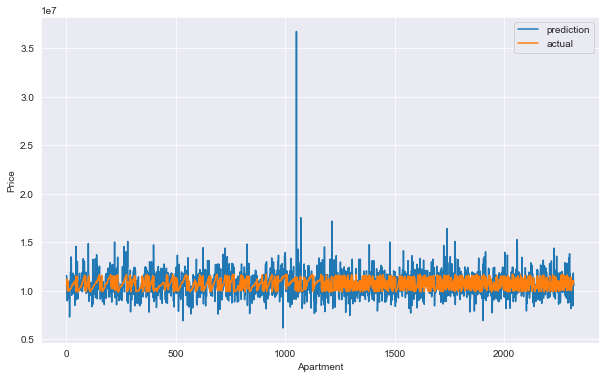

In [98]:
mid_df = pd.DataFrame({ "prediction": test_pred_mid,"actual": test_labels_mid}, index=range(0, 2319))
mid_df.plot(ax=plt.gca(), figsize=(10, 6), ylabel="Price", xlabel="Apartment")
mid_diff = test_pred_mid - test_labels_mid
print(f"Mean error on mid 10%: {np.round(mid_diff.mean())} rubels")
print(f"Mean absolute error on low 95%:", np.round(abs(test_pred_mid - test_labels_mid).mean()), "rubels")
print(f"The error is {np.round(abs(test_pred_mid - test_labels_mid).mean()/mid_mean, 4)} times the mean price")

For this one, we have changed the colors to give a better representation as the prediction is all over the place, while the actual prices stays pretty much the same for all of these. The actual error here is lower than both the other two - which is probably because there are a lot of mid-range houses in the dataset. The model will then be able to predict the prices for these more accurately, as it has seen a lot of similar apartments before. This plot seems to be more inaccurate than the other two, but it is not, as the relative error is smaller than the other two. The actual error on the other hand is higher than the low-end apartments, as the room for error is larger.

Before continuing the analysis, we will create the new distance features we have mentioned. We will try to run a new configuration of features through *AutoML* and analyze the error once again to see if we might have fixed some of the problems. Later on we will also see if the errors might be because there are some differences between the training and test set. If this is the case, we might need to manually tune the training process to counteract this.

## Improving data and adding distance features

As stated numerous times already: we need to improve our dataset to improve performance. We noticed that when adding *distance_center* that it greatly improved our dataset. In this section, we will add features which will be the distance to different things around moscow. This can be the metro, parks, university, hospitals etc. Our hope is that this will make it easier to pinpoint where the expensive apartments are located, and with this, help predictions.

We will also have a look at the other features to see if they help - or damage - the finished RMSLE result. This section will contain a lot of trial and error, so we will try to keep it as clean as possible. You can view this section as another *feature engineering*-section, as it is essentially what we will be doing. It will, however, feature some testing of models and exploration aswell - not just pure feature engineering.

We will start with a clean pallet by once again using the *data* variable introduced early in the notebook. This is the one containing all features directly from file, but some of the fields (like *price* and *area_total*) has been logified.

In [99]:
data.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,15.781156,4.097672,2.602690,3.465736,2.0,2.0,0.0,2.0,0.0,1.0,1.0,4076,1.0,55.544046,37.478055,11.0,2021.0,3.0,9.0,1.0,1.0,1.0,-1.0,-1.0
1,1,-1.0,16.166886,4.488636,2.721295,3.891820,18.0,3.0,2.0,0.0,1.0,1.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,-1.0,0.0
2,2,3.0,16.014916,4.375757,3.157000,3.732896,12.0,3.0,0.0,2.0,1.0,1.0,1.0,5176,1.0,55.663299,37.515335,6.0,2021.0,3.0,15.0,1.0,1.0,1.0,-1.0,-1.0
3,3,-1.0,16.166886,4.488636,2.708050,3.891820,18.0,3.0,0.0,2.0,1.0,1.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,-1.0,0.0
4,4,-1.0,16.447399,4.369448,2.890372,3.583519,7.0,2.0,1.0,0.0,1.0,1.0,1.0,6604,0.0,55.590785,37.451438,11.0,2017.0,2.0,15.0,1.0,1.0,1.0,0.0,0.0


## TESTING MODEL FOR 11. Nov

The randomf model in TestModel

In [109]:
# Seperating training and test data
train_data = categorical[:23285].copy()
labels = train_data["price"]
test_data = categorical[23285:].copy()
test_data.drop("price", 1, inplace=True)
print("Split data into train and test")

# Splitting training data into training and validation, removed the price for each of them afterwards
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, stratify=train_data.price.round(), test_size=0.33)
x_train.drop("price", 1, inplace=True)
x_test.drop("price", 1, inplace=True)
print("Validation data created and price dropped")
print("The number of features are now:", x_train.shape[1])

print("Fitting model...")
model = TestModel(x_train, y_train)
pipeline = model.fit()
test_pred = np.round([np.expm1(pred) for pred in model.predict(x_test)])
test_labels = np.round([np.expm1(lab)for lab in y_test])
print("Fitting complete")

res = pd.DataFrame([(test_labels[i], test_pred[i]) for i in range(len(test_pred))], columns=["actual", "prediction"])
print("RMLSE: %s" % model.root_mean_squared_log_error(test_labels, test_pred))
res.to_csv("./split.csv", index=False)

pred = [np.expm1(p) for p in model.predict(test_data)]
model.save_predictions(pred)


Split data into train and test
Validation data created and price dropped
The number of features are now: 43
Fitting model...
Fitting complete
RMLSE: 0.14485050152031168


,id,price_prediction
0,23285,33342196.0
1,23286,10665833.0
2,23287,8360076.0
3,23288,13331898.0
4,23289,7007663.5
...,...,...
9932,33217,34282360.0
9933,33218,26011592.0
9934,33219,13109094.0
9935,33220,13164871.0
